# Air Quality Analytics Collaborative Framework (AQACF) API Demonstration

## Use Cases
This notebook highlits some of the analytics and visualization capabilities of AQACF with six use cases:
1. 2021 Alisal Wildfire
2. 2020 California Wildfires
3. 2018 Carr Wildfire
4. Los Angeles ports backlog Fall 2021
5. Fireworks during 4th of July 2022 in Los Angeles county
6. Air Pollution in the Yellow Sea
7. Fires and Thermal Daily Difference in Southeast Asia in 2022

## Libraries and Functions

### Libraries
The following libraries are needed to support this notebook

In [1]:
# Libraries
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

import ideas_modules.plotting as plotting
import ideas_modules.ideas_processing as ideas_processing

import xml.etree.ElementTree as xmlet

import requests
import pandas as pd

from shapely.geometry import box
import time 
import xarray as xr
import numpy as np
from typing import List

from datetime import datetime, timedelta
from tabulate import tabulate

from IPython.display import Image
from owslib.util import Authentication
from owslib.wms import WebMapService
from PIL import Image as I
from PIL import ImageDraw



## AQACF DATA Inventory

In [2]:
# Default values
units = {
    'pm25': 'µg/m³',
    'O3': 'mol m-2',
    'SO2': 'mmol/m2',
    'NO2': 'umol/m2',
    'CO': 'ppb',
    'CH4': 'ppb'
}

# TROPOMI Datasets
NO2_dataset  = 'TROPOMI-0.1deg-CA-NO2'
NO2_computed_climatology = 'TROPOMI-0.1deg-CA-NO2_clim'

SO2_dataset  = 'TROPOMI-0.1deg-CA-SO2'
SO2_computed_climatology = 'TROPOMI-0.1deg-CA-SO2_clim'

O3_dataset  = 'TROPOMI-0.1deg-CA-O3'
O3_computed_climatology = 'TROPOMI-0.1deg-CA-O3_clim'

CO_dataset  = 'TROPOMI-0.1deg-CA-CO'
CO_computed_climatology = 'TROPOMI-0.1deg-CA-CO_clim'

CH4_dataset  = 'TROPOMI-0.1deg-CA-CH4'
CH4_computed_climatology = 'TROPOMI-0.1deg-CA-CH4_clim'

In [3]:
aq_base_url = 'https://ideas-digitaltwin.jpl.nasa.gov/nexus/'
r = requests.get(f'{aq_base_url}/list', verify=False).json()
inv_df = pd.DataFrame(r)[['title', 'iso_start', 'iso_end']].dropna(how='all')
inv_df.sort_values('title')

title  \
0                    GLDAS_CLSM10_3H_2_1_global_Qs_acc   
1                   GLDAS_CLSM10_3H_2_1_global_Qsb_acc   
2                    GLDAS_NOAH10_3H_2_1_global_Qs_acc   
3                   GLDAS_NOAH10_3H_2_1_global_Qsb_acc   
4                     GLDAS_VIC10_3H_2_1_global_Qs_acc   
..                                                 ...   
240  wustl-0.1degx0.1deg-daily-ca-SpeciesConc_SO2_D...   
241    wustl-0.1degx0.1deg-daily-ca-SpeciesConc_SO2_D8   
242  wustl-0.1degx0.1deg-daily-ca-SpeciesConc_SO2_D...   
243    wustl-0.1degx0.1deg-daily-ca-SpeciesConc_SO2_D9   
244  wustl-0.1degx0.1deg-daily-ca-SpeciesConc_SO2_D...   

                    iso_start                   iso_end  
0    2018-10-01T00:00:00+0000  2022-03-01T21:00:00+0000  
1    2018-10-01T00:00:00+0000  2022-03-01T21:00:00+0000  
2    2018-10-01T00:00:00+0000  2022-03-01T21:00:00+0000  
3    2018-10-01T00:00:00+0000  2022-03-01T21:00:00+0000  
4    2018-10-01T00:00:00+0000  2022-03-01T21:00:00+0000  
..                        ...                       ...  
240  1970-01-01T00:00:00+0000  1970-12-01T00:00:00+0000  
241  2017-03-01T12:00:00+0000  2018-12-31T12:00:00+0000  
242  1970-01-01T00:00:00+0000  1970-12-01T00:00:00+0000  
243  2017-03-01T12:00:00+0000  2018-12-31T12:00:00+0000  
244  1970-01-01T00:00:00+0000  1970-12-01T00:00:00+0000  

[247 rows x 3 columns]

# 2021 Alisal Wildfire

For much of summer 2021, large fires decimated forests in Northern California. By the middle of October, those fires were mostly extinguished or burned out, but red-flag warnings and fierce fires had begun to cause problems in the chaparral shrublands and grasslands of Central and Southern California.

After igniting near the Alisal reservoir on October 11, the fast-moving blaze charred 13,400 acres (54 square kilometers) by the afternoon of October 13. At that time, the fire was 5 percent contained. With the blaze threatening at least 100 structures, authorities issued evacuation orders and closed parts of Highway 101. The fire was designated as fully contained on Sep. 20, 2021 with a total burn time of 39 days.

In addition to destroying natural habitats wildfires emit high levels of Sulfur Dioxide (SO2) and Nitrogen Dioxide (NO2) while also destroying Ozone (O3) levels.

### Area of Interest

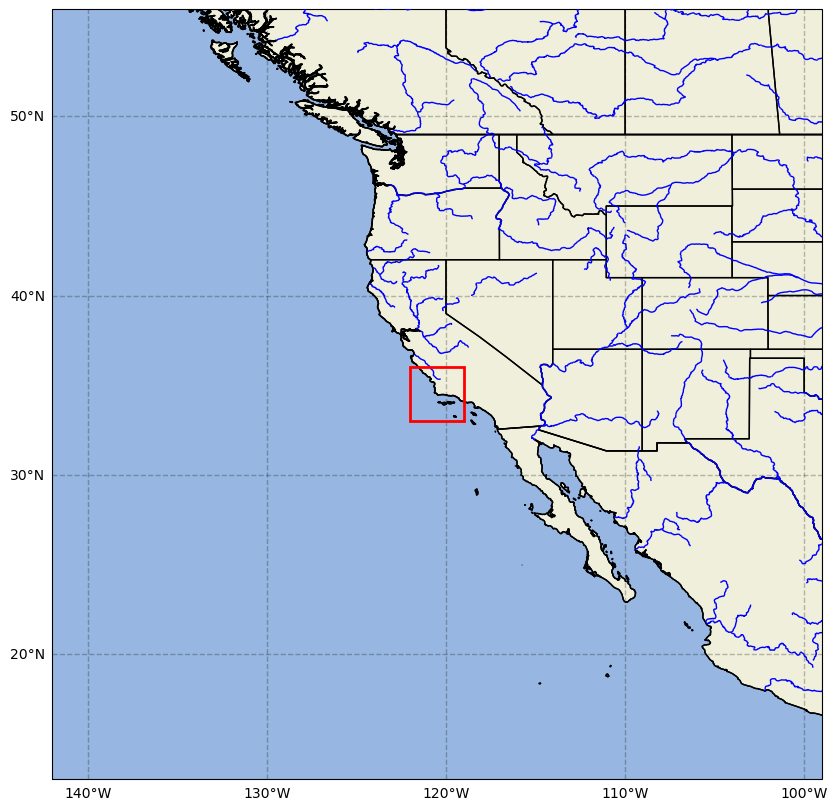

In [4]:
wildfires_bb = {'min_lon': -122, 'max_lon': -119, 'min_lat': 33, 'max_lat': 36}
wildfires_start_time = datetime(2020,8,1)
wildfires_end_time = datetime(2020,11,1)

wildfires_bbox = box(wildfires_bb['min_lon'], wildfires_bb['min_lat'], wildfires_bb['max_lon'], wildfires_bb['max_lat'])
plotting.map_box(wildfires_bb)

### Alisal Smoke Plume Visualization
On October 13, 2021, the Moderate Resolution Imaging Spectroradiometer (MODIS) on NASA’s Aqua satellite captured this image of the Alisal fire northwest of Santa Barbara. Strong northerly winds pushed plumes of smoke over the Pacific Ocean. 

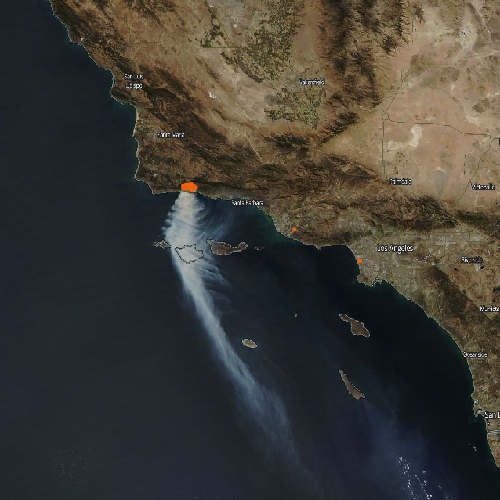

In [5]:
# Connect to GIBS WMS Service
wms = WebMapService('https://gibs.earthdata.nasa.gov/wms/epsg4326/best/wms.cgi?', version='1.3.0')

img = wms.getmap(layers=['BlueMarble_NextGeneration',
                         'MODIS_Aqua_CorrectedReflectance_TrueColor',
                         'MODIS_Aqua_Thermal_Anomalies_All',
                         'Reference_Features',
                         'Reference_Labels'],  # Layers
                 srs='epsg:4326',  # Map projection
                 bbox=(-122,32,-117,36),  # Bounds (min-lon, min-lat, max-lon, max-lat)
                 size=(500, 500),  # Image size
                 time='2021-10-12',  # Time of data
                 format='image/png',  # Image format
                 transparent=True)  # Nodata transparency

# View image
Image(img.read())

In [6]:
alisal_bb = {'min_lon': -120.559662, 'max_lon': -120.179261, 'min_lat': 34.308912, 'max_lat': 34.660953}
alisal_start_time = datetime(2021,10,1)
alisal_end_time = datetime(2021,11,20)

### NO2 Levels

Wildfires are a significant source of nitrogen oxides (NOx ≡ NO + NO2) to the global atmosphere, representing approximately 15% of the total NOx budget.

The graph below shows the NO2 output lifecycle of the Alisal wildfire (burned 10-11-2021 through 11-20-2021).

#### NO2 Spatial Mean

url
 https://ideas-digitaltwin.jpl.nasa.gov/nexus//timeSeriesSpark?ds=TROPOMI-0.1deg-CA-NO2&minLon=-120.559662&minLat=34.308912&maxLon=-120.179261&maxLat=34.660953&startTime=2021-10-01T00:00:00Z&endTime=2021-11-20T00:00:00Z&lowPassFilter=False

Waiting for response from IDEAS...took 3.736357624991797 seconds


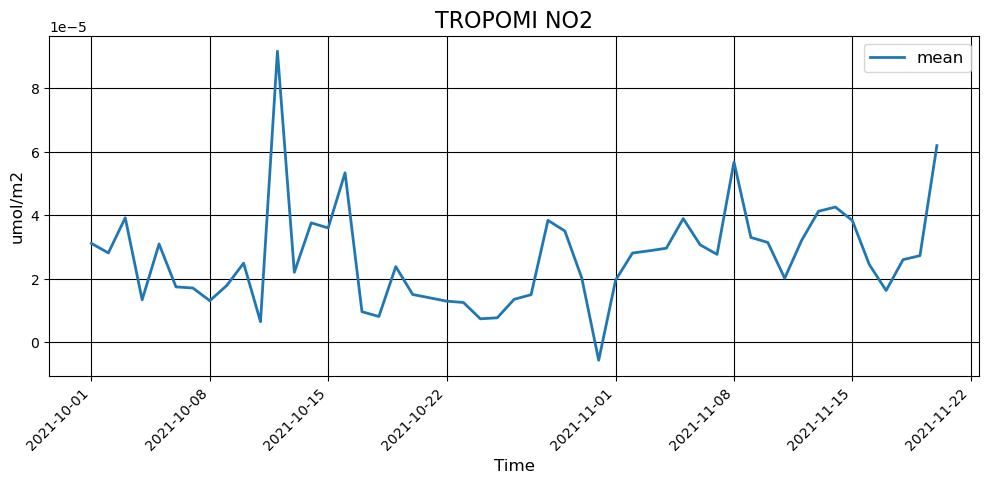

In [7]:
wildfires_omi_no2 = ideas_processing.spatial_timeseries(aq_base_url, NO2_dataset, alisal_bb, alisal_start_time, alisal_end_time)
plotting.timeseries_plot([(wildfires_omi_no2['mean'], 'mean')], 'Time', units['NO2'], 'TROPOMI NO2')

#### NO2 Daily Difference

url
 https://ideas-digitaltwin.jpl.nasa.gov/nexus//dailydifferenceaverage_spark?dataset=TROPOMI-0.1deg-CA-NO2&climatology=TROPOMI-0.1deg-CA-NO2_clim&b=-120.559662,34.308912,-120.179261,34.660953&startTime=2021-10-01T00:00:00Z&endTime=2021-11-20T00:00:00Z

Waiting for response from IDEAS... took 2.7736892090179026 seconds


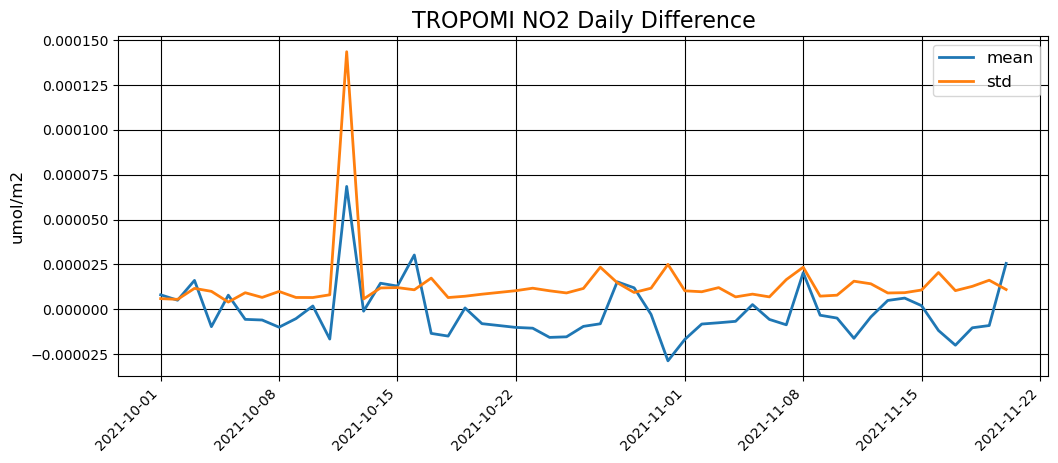

In [8]:
NO2_daily_diff_data = ideas_processing.daily_diff(aq_base_url, NO2_dataset, NO2_computed_climatology, alisal_bb, alisal_start_time, alisal_end_time)
plotting.timeseries_plot([(NO2_daily_diff_data['mean'], 'mean'), (NO2_daily_diff_data['std'], 'std')], '', 'umol/m2', title='TROPOMI NO2 Daily Difference')

#### NO2 Latitude Hovmöller

url
 https://ideas-digitaltwin.jpl.nasa.gov/nexus//latitudeTimeHofMoellerSpark?ds=TROPOMI-0.1deg-CA-NO2&b=-120.559662,34.308912,-120.179261,34.660953&startTime=2021-10-01T00:00:00Z&endTime=2021-11-20T00:00:00Z

Waiting for response from IDEAS... took 0.7047119999770075 seconds


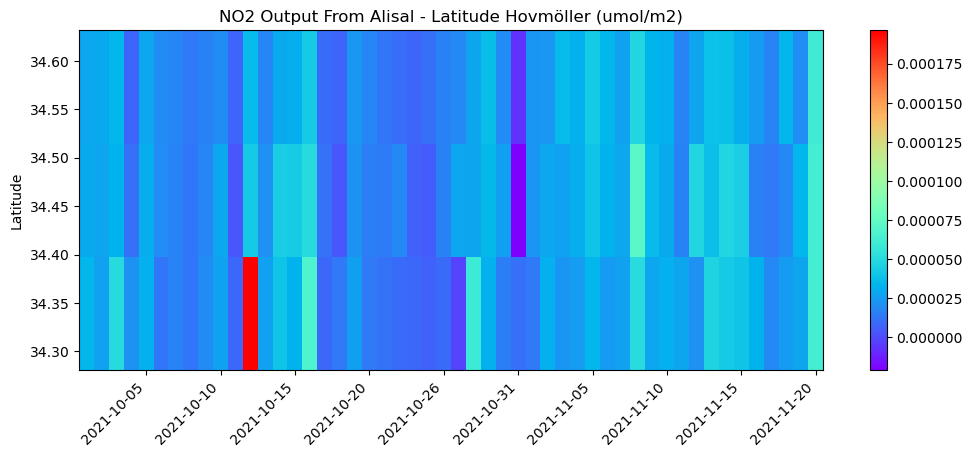

In [9]:
alisal_parameters = (aq_base_url, NO2_dataset, alisal_bb, alisal_start_time, alisal_end_time)
alisal_lat_hov = ideas_processing.hofmoeller(*alisal_parameters, dim='latitude')
alisal_hov_title = 'NO2 Output From Alisal - Latitude Hovmöller (umol/m2)'
plotting.heatmap(alisal_lat_hov['mean'].transpose(), '', 'Latitude', alisal_hov_title)

#### NO2 Longitude Hovmöller

url
 https://ideas-digitaltwin.jpl.nasa.gov/nexus//longitudeTimeHofMoellerSpark?ds=TROPOMI-0.1deg-CA-NO2&b=-120.559662,34.308912,-120.179261,34.660953&startTime=2021-10-01T00:00:00Z&endTime=2021-11-20T00:00:00Z

Waiting for response from IDEAS... took 0.7495002500363626 seconds


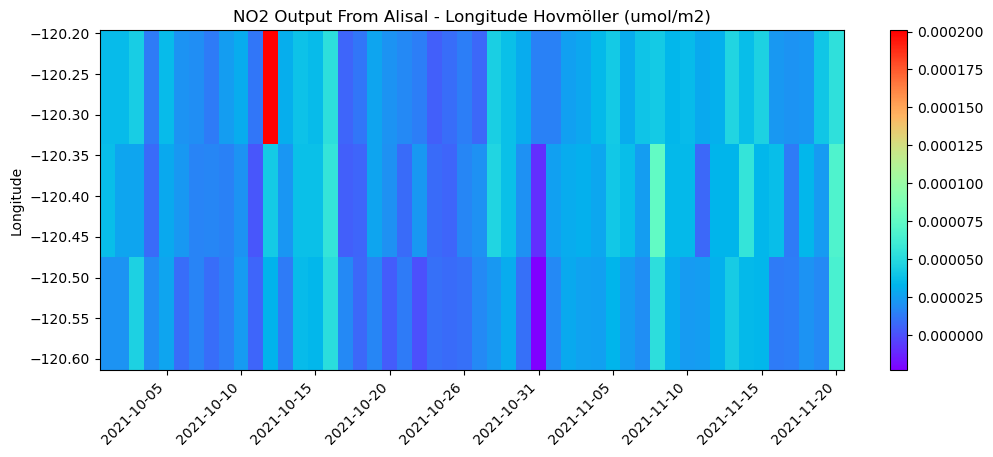

In [10]:
alisal_parameters = (aq_base_url, NO2_dataset, alisal_bb, alisal_start_time, alisal_end_time)
alisal_lon_hov = ideas_processing.hofmoeller(*alisal_parameters, dim='longitude')
alisal_hov_title = 'NO2 Output From Alisal - Longitude Hovmöller (umol/m2)'
plotting.heatmap(alisal_lon_hov['mean'].transpose(), '', 'Longitude', alisal_hov_title)

### O3 Levels

Wildfires harm the ozone layer by depleting Ozone levels putting us at an increased risk from ultraviolet (UV) radiation. 
Researchers caution that if major fires become more frequent with a changing climate, more damaging ultraviolet radiation from the sun will reach the ground.

#### O3 Spatial Mean

url
 https://ideas-digitaltwin.jpl.nasa.gov/nexus//timeSeriesSpark?ds=TROPOMI-0.1deg-CA-O3&minLon=-120.559662&minLat=34.308912&maxLon=-120.179261&maxLat=34.660953&startTime=2021-10-01T00:00:00Z&endTime=2021-11-20T00:00:00Z&lowPassFilter=False

Waiting for response from IDEAS...took 0.925101833010558 seconds


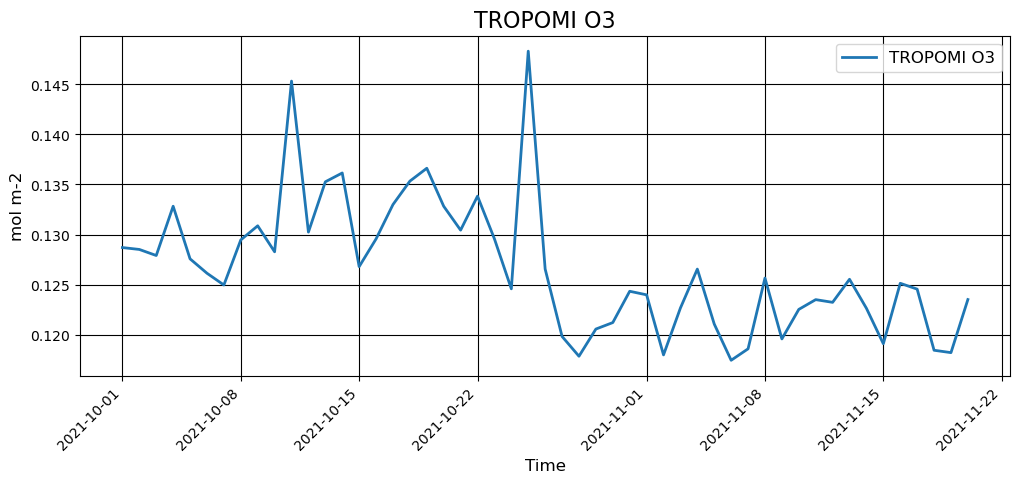

In [11]:
wildfires_omi_O3 = ideas_processing.spatial_timeseries(aq_base_url, O3_dataset, alisal_bb, alisal_start_time, alisal_end_time)
plotting.timeseries_plot([(wildfires_omi_O3['mean'], 'TROPOMI O3')], 'Time', units['O3'], 'TROPOMI O3')

#### O3 Daily Difference

url
 https://ideas-digitaltwin.jpl.nasa.gov/nexus//dailydifferenceaverage_spark?dataset=TROPOMI-0.1deg-CA-O3&climatology=TROPOMI-0.1deg-CA-O3_clim&b=-120.559662,34.308912,-120.179261,34.660953&startTime=2021-10-01T00:00:00Z&endTime=2021-11-20T00:00:00Z

Waiting for response from IDEAS... took 2.598868708999362 seconds


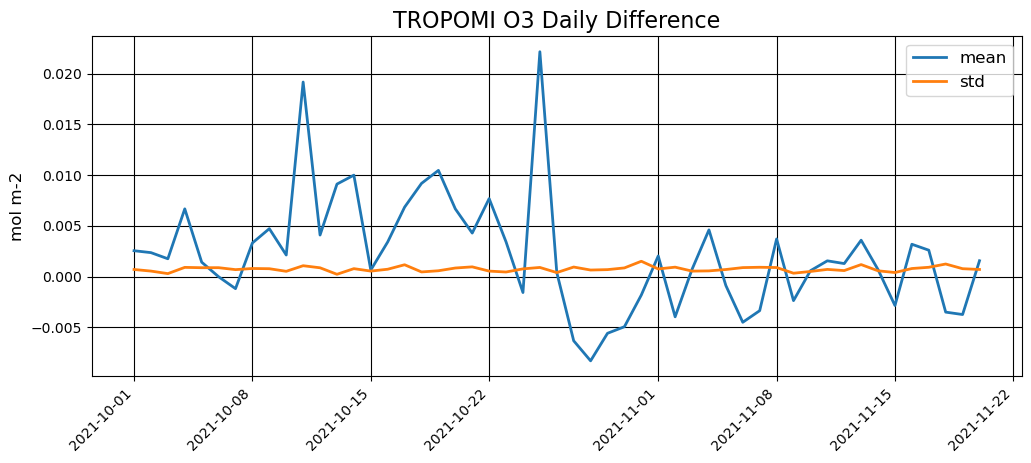

In [12]:
pakistan_daily_diff_data = ideas_processing.daily_diff(aq_base_url, O3_dataset, O3_computed_climatology, alisal_bb, alisal_start_time, alisal_end_time)
plotting.timeseries_plot([(pakistan_daily_diff_data['mean'], 'mean'), (pakistan_daily_diff_data['std'], 'std')], '', 'mol m-2', title='TROPOMI O3 Daily Difference')

# 2021 California Wildfires 
The 2021 California wildfire season was one of the worst on record with about 2.5 million acres burned.
It's estimated that California wildfires emitted 75 million metric tons of carbon dioxide in just three months (June - August 2021).

75 million metric tons of carbon dioxide is equal to:
> - 16,310,993 passenger cars driven for a year (Greenhouse Gas - GHG)
> - 188,489,840,317 miles driven by an average passenger vehicle (GHG)
> - 8,439,293,350 gallons of gasoline consumed (Carbon Dioxide Emissions – CO2)
> - 82,896,993 pounds of coal burned (CO2)
> - 173,640,855 barrels of oil consumed (CO2)

### Area of Interest

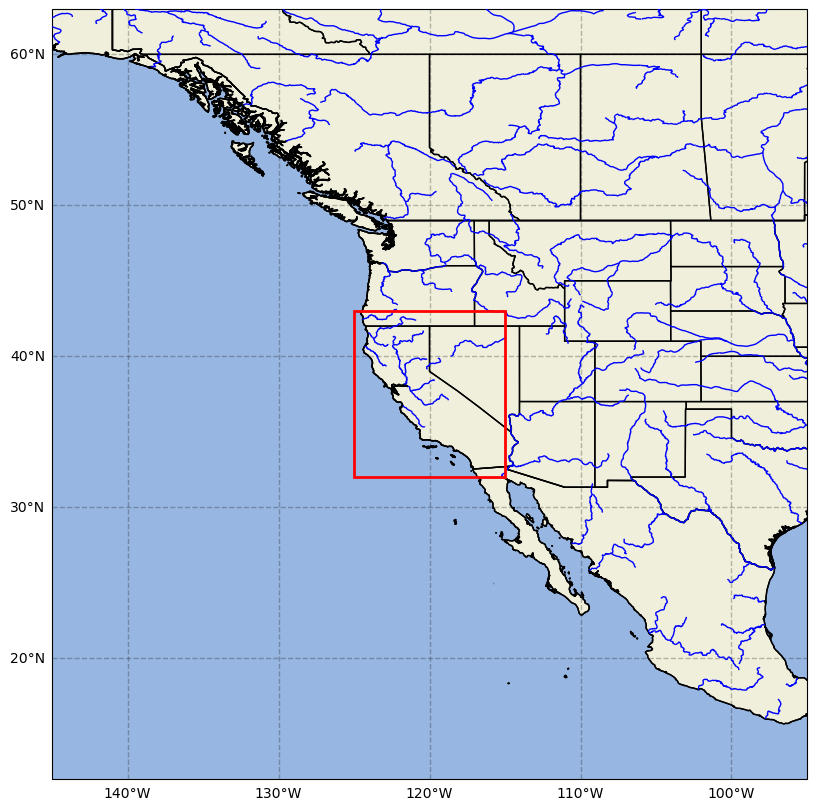

In [13]:
wildfires_bb = {'min_lon': -125, 'max_lon': -115, 'min_lat': 32, 'max_lat': 43}
wildfires_start_time = datetime(2021,4,1)
wildfires_end_time = datetime(2021,9,1)

wildfires_bbox = box(wildfires_bb['min_lon'], wildfires_bb['min_lat'], wildfires_bb['max_lon'], wildfires_bb['max_lat'])
plotting.map_box(wildfires_bb)


### SO2 Levels
Sulfur dioxide (SO2) is a foul-smelling toxic gas which can damage trees and plants, inhibit plant growth, and damage sensitive ecosystems and waterways. It also can contribute to respiratory illness and aggravate existing heart and lung conditions.

Additionally sulfur dioxide can create secondary pollutants, such as sulfate aerosols, particulate matter, and acid rain, once released into the air.

#### SO2 Spatial Mean

url
 https://ideas-digitaltwin.jpl.nasa.gov/nexus//timeSeriesSpark?ds=TROPOMI-0.1deg-CA-SO2&minLon=-125&minLat=32&maxLon=-115&maxLat=43&startTime=2021-04-01T00:00:00Z&endTime=2021-09-01T00:00:00Z&lowPassFilter=False

Waiting for response from IDEAS...took 1.9266589590115473 seconds


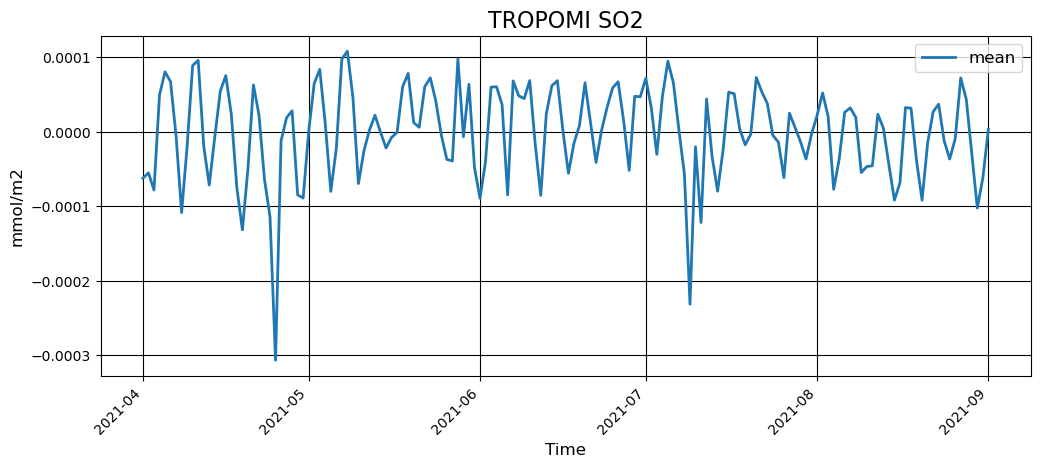

In [14]:
tropomi_so2 = ideas_processing.spatial_timeseries(aq_base_url, SO2_dataset, wildfires_bb, wildfires_start_time, wildfires_end_time)
plotting.timeseries_plot([(tropomi_so2['mean'], 'mean')], 'Time', units['SO2'], 'TROPOMI SO2')

#### SO2 Daily Difference

url
 https://ideas-digitaltwin.jpl.nasa.gov/nexus//dailydifferenceaverage_spark?dataset=TROPOMI-0.1deg-CA-SO2&climatology=TROPOMI-0.1deg-CA-SO2_clim&b=-125,32,-115,43&startTime=2021-04-01T00:00:00Z&endTime=2021-09-01T00:00:00Z

Waiting for response from IDEAS... took 12.270157416001894 seconds


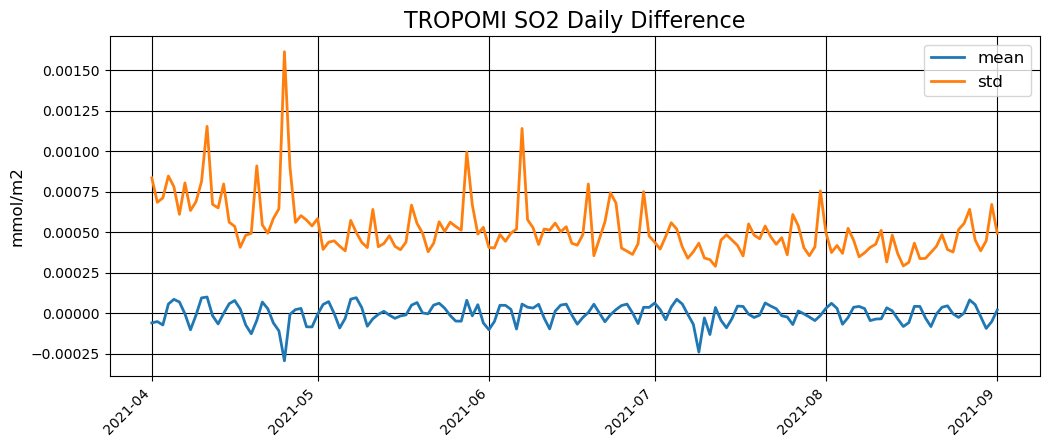

In [15]:
pakistan_daily_diff_data = ideas_processing.daily_diff(aq_base_url, SO2_dataset, SO2_computed_climatology, wildfires_bb, wildfires_start_time, wildfires_end_time)
plotting.timeseries_plot([(pakistan_daily_diff_data['mean'], 'mean'), (pakistan_daily_diff_data['std'], 'std')], '', 'mmol/m2', title='TROPOMI SO2 Daily Difference')

#### SO2 Temporal Variance

url
 https://ideas-digitaltwin.jpl.nasa.gov/nexus//varianceSpark?ds=TROPOMI-0.1deg-CA-SO2&minLon=-125&minLat=32&maxLon=-115&maxLat=43&startTime=2021-04-01T00:00:00Z&endTime=2021-09-01T00:00:00Z

Waiting for response from IDEAS... took 9.40754220803501 seconds


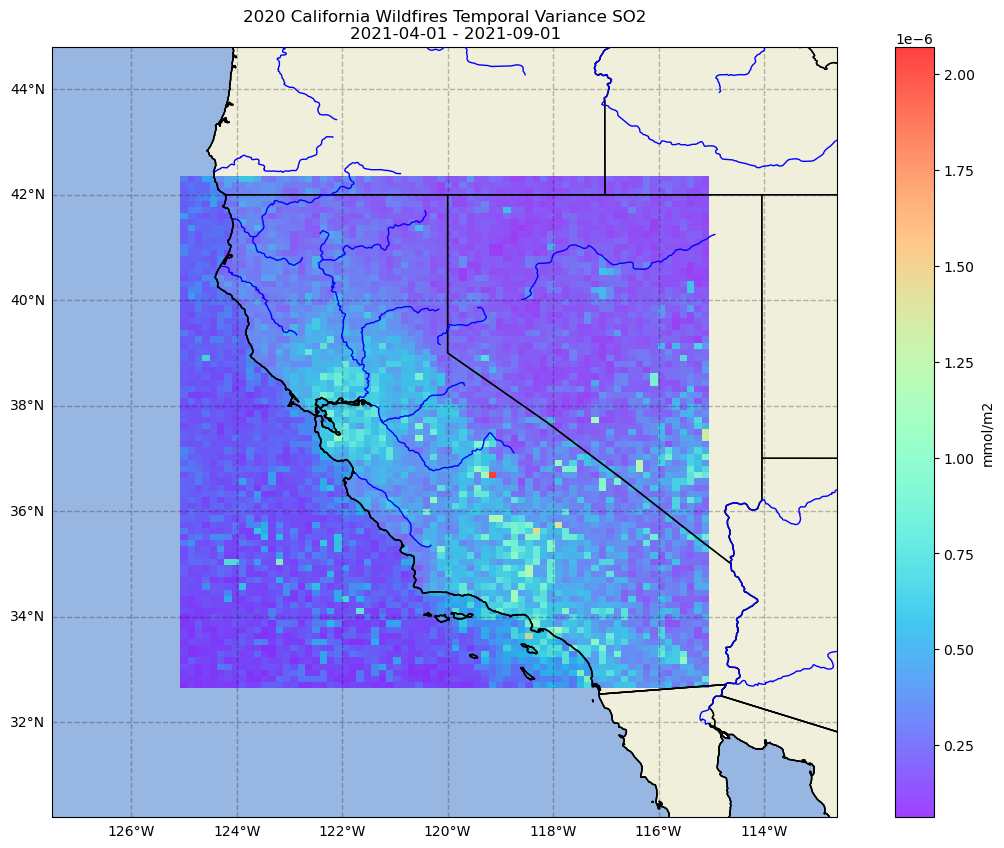

In [16]:
wildfires_temp_var_tropomi_so2 = ideas_processing.temporal_variance(aq_base_url, SO2_dataset, wildfires_bb, wildfires_start_time, wildfires_end_time)
wildfire_variance_title = f'2020 California Wildfires Temporal Variance SO2\n\
    {str(wildfires_start_time)[:10]} - {str(wildfires_end_time)[:10]}'
plotting.map_data(wildfires_temp_var_tropomi_so2, wildfire_variance_title, cb_label=units['SO2'])

### O3 Levels

#### O3 Spatial Mean

url
 https://ideas-digitaltwin.jpl.nasa.gov/nexus//timeSeriesSpark?ds=TROPOMI-0.1deg-CA-O3&minLon=-125&minLat=32&maxLon=-115&maxLat=43&startTime=2021-04-01T00:00:00Z&endTime=2021-09-01T00:00:00Z&lowPassFilter=False

Waiting for response from IDEAS...took 2.376125917013269 seconds


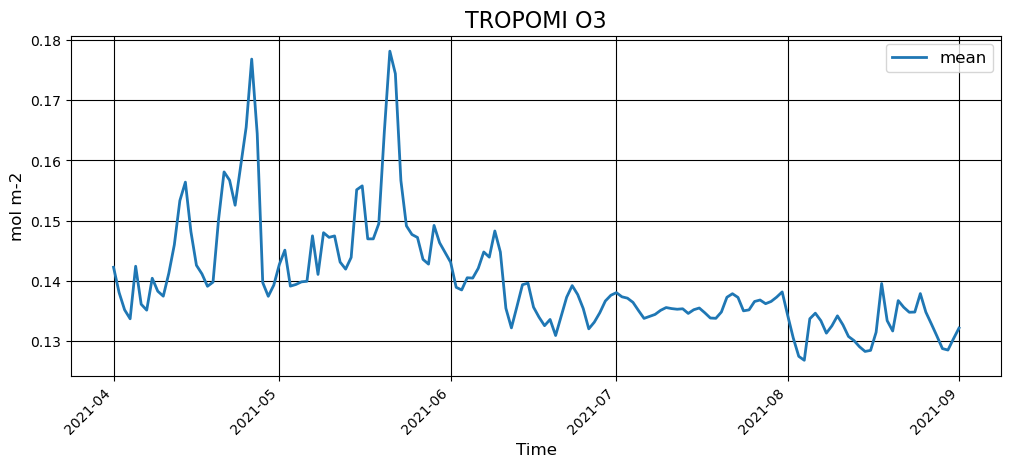

In [17]:
tropomi_o3 =  ideas_processing.spatial_timeseries(aq_base_url, O3_dataset, wildfires_bb, wildfires_start_time, wildfires_end_time)
plotting.timeseries_plot([(tropomi_o3['mean'], 'mean')], 'Time', units['O3'], 'TROPOMI O3')

#### O3 Daily Difference

url
 https://ideas-digitaltwin.jpl.nasa.gov/nexus//dailydifferenceaverage_spark?dataset=TROPOMI-0.1deg-CA-O3&climatology=TROPOMI-0.1deg-CA-O3_clim&b=-125,32,-115,43&startTime=2021-04-01T00:00:00Z&endTime=2021-09-01T00:00:00Z

Waiting for response from IDEAS... took 11.89860062499065 seconds


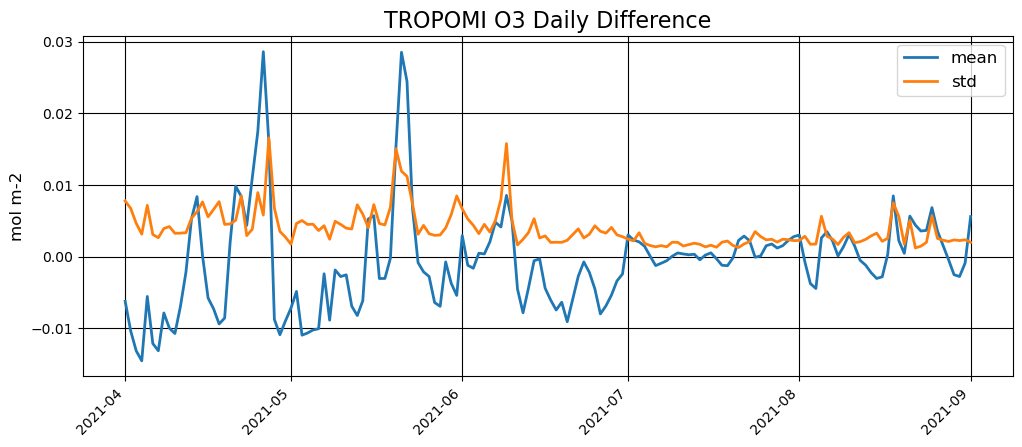

In [18]:
wildfire_O3_daily_diff_data = ideas_processing.daily_diff(aq_base_url, O3_dataset, O3_computed_climatology, wildfires_bb, wildfires_start_time, wildfires_end_time)
plotting.timeseries_plot([(wildfire_O3_daily_diff_data['mean'], 'mean'), (wildfire_O3_daily_diff_data['std'], 'std')], '', 'mol m-2', title='TROPOMI O3 Daily Difference')

#### O3 Temporal Mean

url
 https://ideas-digitaltwin.jpl.nasa.gov/nexus//timeAvgMapSpark?ds=TROPOMI-0.1deg-CA-O3&b=-125,32,-115,43&startTime=2021-04-01T00:00:00Z&endTime=2021-09-01T00:00:00Z

Waiting for response from IDEAS... took 8.273681249993388 seconds


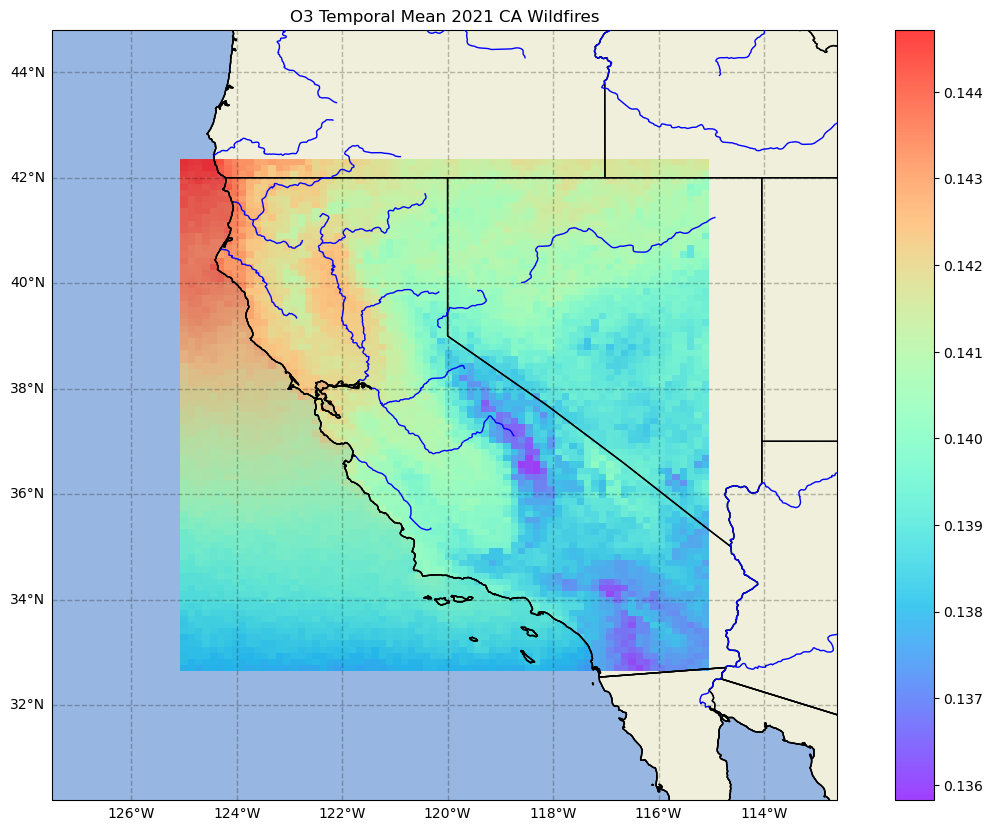

In [19]:
O3_temporal_mean_data = ideas_processing.temporal_mean(aq_base_url, O3_dataset, wildfires_bb, wildfires_start_time, wildfires_end_time)
plotting.map_data(O3_temporal_mean_data, "O3 Temporal Mean 2021 CA Wildfires")

### NO2 Levels

#### NO2 Spatial Mean

url
 https://ideas-digitaltwin.jpl.nasa.gov/nexus//timeSeriesSpark?ds=TROPOMI-0.1deg-CA-NO2&minLon=-125&minLat=32&maxLon=-115&maxLat=43&startTime=2021-04-01T00:00:00Z&endTime=2021-09-01T00:00:00Z&lowPassFilter=False

Waiting for response from IDEAS...took 1.5849437500000931 seconds


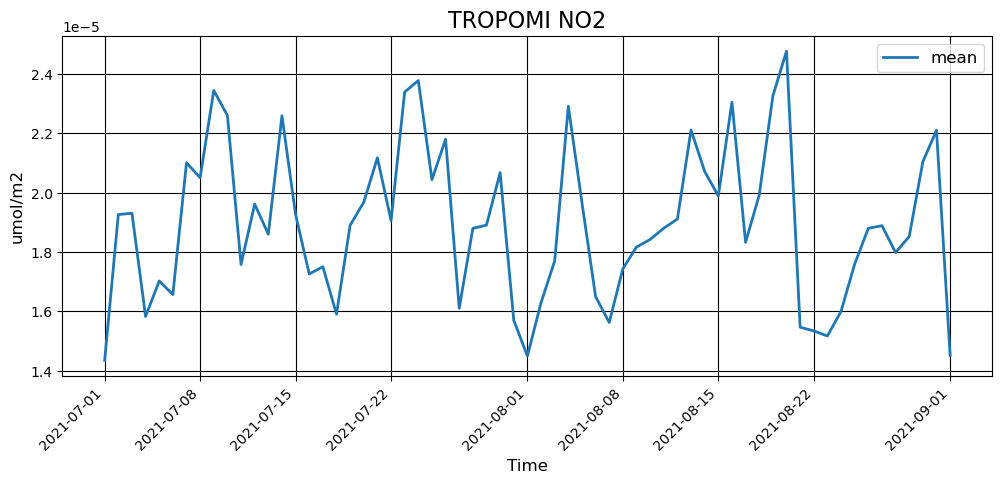

In [20]:
wildfires_omi_no2 = ideas_processing.spatial_timeseries(aq_base_url, NO2_dataset , wildfires_bb, wildfires_start_time, wildfires_end_time)
plotting.timeseries_plot([(wildfires_omi_no2['mean'], 'mean')], 'Time', units['NO2'], 'TROPOMI NO2')

#### NO2 Daily Difference

url
 https://ideas-digitaltwin.jpl.nasa.gov/nexus//dailydifferenceaverage_spark?dataset=TROPOMI-0.1deg-CA-NO2&climatology=TROPOMI-0.1deg-CA-NO2_clim&b=-125,32,-115,43&startTime=2021-04-01T00:00:00Z&endTime=2021-09-01T00:00:00Z

Waiting for response from IDEAS... took 4.40393154200865 seconds


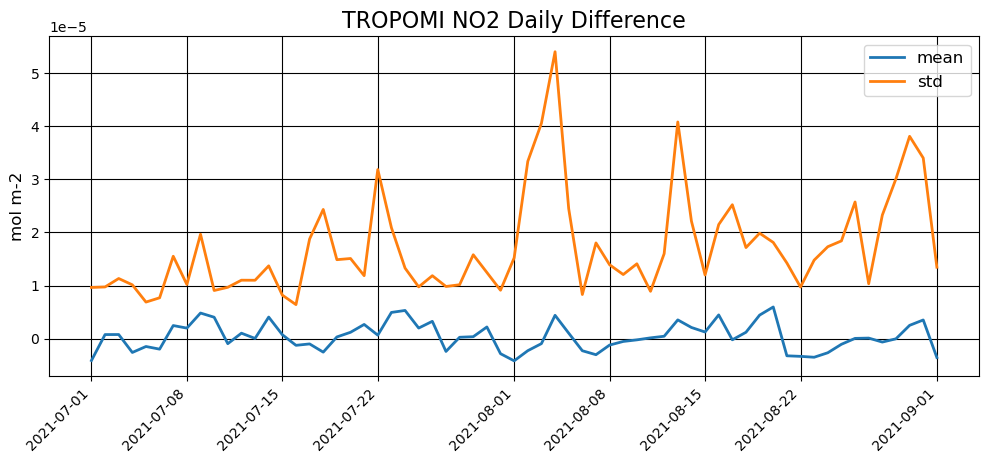

In [21]:
wildfire_NO2_daily_diff_data = ideas_processing.daily_diff(aq_base_url, NO2_dataset, NO2_computed_climatology, wildfires_bb, wildfires_start_time, wildfires_end_time)
plotting.timeseries_plot([(wildfire_NO2_daily_diff_data['mean'], 'mean'), (wildfire_NO2_daily_diff_data['std'], 'std')], '', 'mol m-2', title='TROPOMI NO2 Daily Difference')

#### NO2 Latitude Hovmöller

url
 https://ideas-digitaltwin.jpl.nasa.gov/nexus//latitudeTimeHofMoellerSpark?ds=TROPOMI-0.1deg-CA-NO2&b=-125,32,-115,43&startTime=2021-04-01T00:00:00Z&endTime=2021-09-01T00:00:00Z

Waiting for response from IDEAS... took 4.360425334016327 seconds


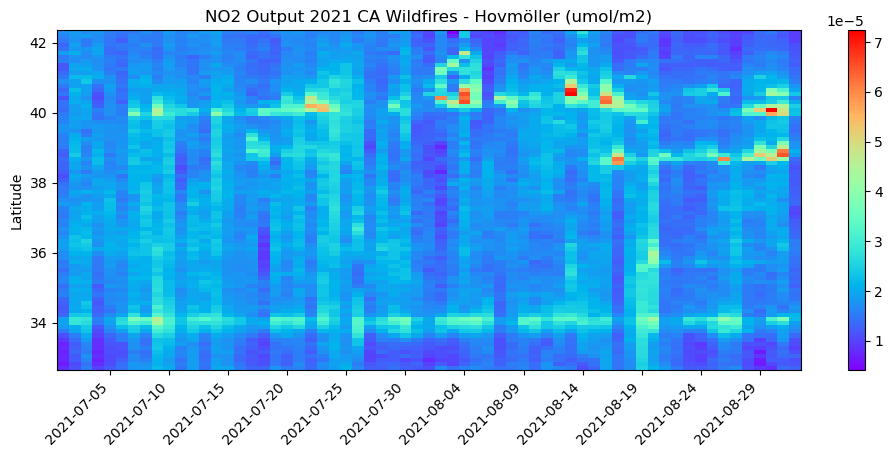

In [22]:
wildfires_parameters = (aq_base_url, NO2_dataset, wildfires_bb, wildfires_start_time, wildfires_end_time)
wildfires_lat_hov = ideas_processing.hofmoeller(*wildfires_parameters, dim='latitude')
wildfires_hov_title = 'NO2 Output 2021 CA Wildfires - Hovmöller (umol/m2)'
plotting.heatmap(wildfires_lat_hov['mean'].transpose(), '', 'Latitude', wildfires_hov_title)

#### NO2 Temporal Mean

url
 https://ideas-digitaltwin.jpl.nasa.gov/nexus//timeAvgMapSpark?ds=TROPOMI-0.1deg-CA-NO2&b=-125,32,-115,43&startTime=2021-04-01T00:00:00Z&endTime=2021-09-01T00:00:00Z

Waiting for response from IDEAS... took 4.7072262080037035 seconds


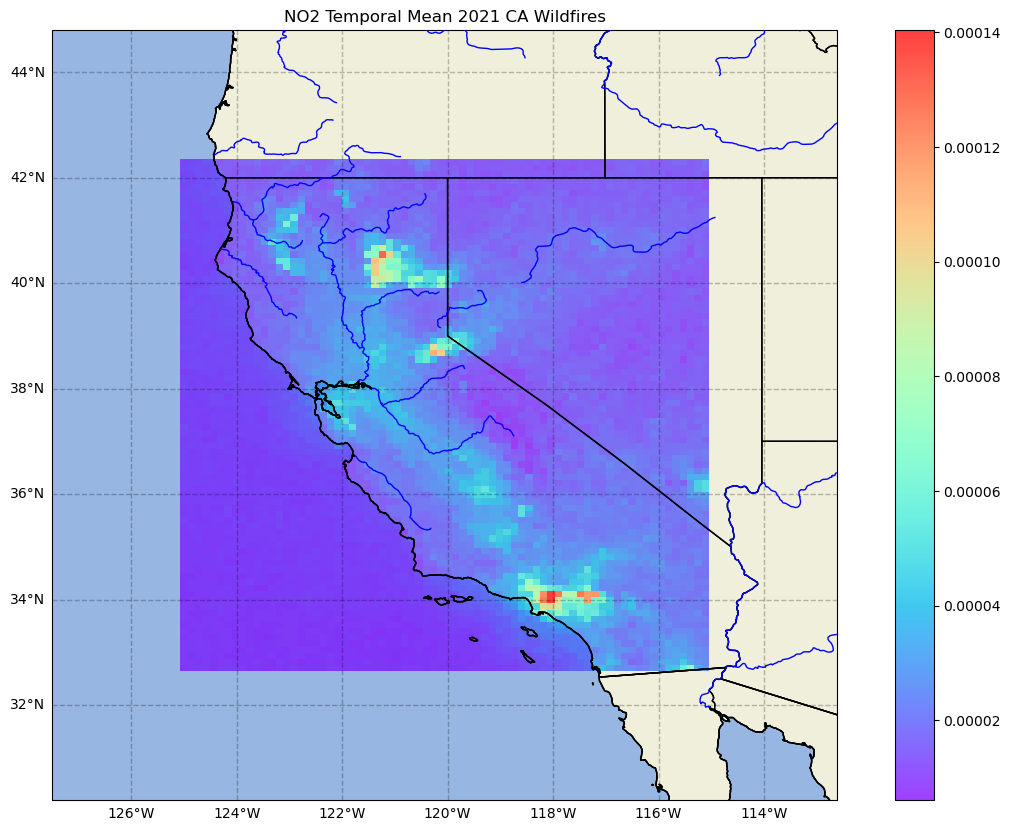

In [23]:
NO2_temporal_mean_data = ideas_processing.temporal_mean(aq_base_url, NO2_dataset, wildfires_bb, wildfires_start_time, wildfires_end_time)
plotting.map_data(NO2_temporal_mean_data, "NO2 Temporal Mean 2021 CA Wildfires")

# 2018 Carr Wildfire
The Carr Fire was a large wildfire that burned in Shasta and Trinity Counties in California, United States. The fire started on July 23, 2018 and burned 229,651 acres, before it was 100% contained late on August 30, 2018.

### Area of interest

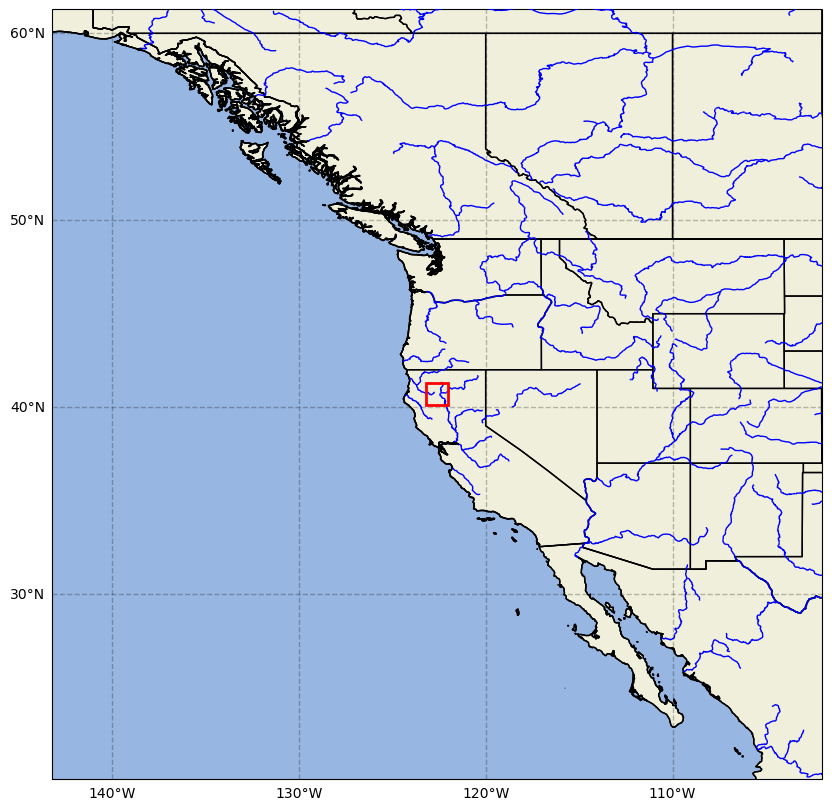

In [24]:
carr_bb = {
    'min_lon': -123.2,
    'max_lon': -122,
    'min_lat': 40.1,
    'max_lat': 41.3
}

carr_start_time = datetime(2018,6,1)
carr_end_time = datetime(2018,9,1)

carr_bbox = box(carr_bb['min_lon'], carr_bb['min_lat'], carr_bb['max_lon'], carr_bb['max_lat'])
plotting.map_box(carr_bb)

### NO2 Levels

#### NO2 Spatial Mean

url
 https://ideas-digitaltwin.jpl.nasa.gov/nexus//timeSeriesSpark?ds=wustl-0.1degx0.1deg-daily-ca-SpeciesConc_NO2_D0&minLon=-123.2&minLat=40.1&maxLon=-122&maxLat=41.3&startTime=2018-06-01T00:00:00Z&endTime=2018-09-01T00:00:00Z&lowPassFilter=False

Waiting for response from IDEAS...took 0.936275709012989 seconds


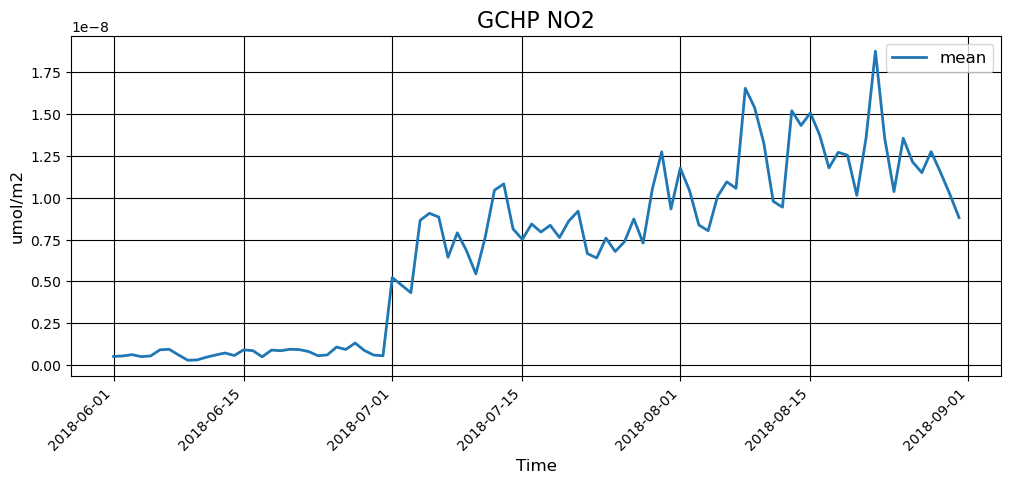

In [25]:
carr_NO2 = ideas_processing.spatial_timeseries(aq_base_url, 'wustl-0.1degx0.1deg-daily-ca-SpeciesConc_NO2_D0', carr_bb, carr_start_time, carr_end_time)
plotting.timeseries_plot([(carr_NO2['mean'], 'mean')], 'Time', units['NO2'], 'GCHP NO2')

#### NO2 Temporal Variance

url
 https://ideas-digitaltwin.jpl.nasa.gov/nexus//varianceSpark?ds=wustl-0.1degx0.1deg-daily-ca-SpeciesConc_NO2_D0&minLon=-123.2&minLat=40.1&maxLon=-122&maxLat=41.3&startTime=2018-06-01T00:00:00Z&endTime=2018-09-01T00:00:00Z

Waiting for response from IDEAS... took 1.3736037079943344 seconds


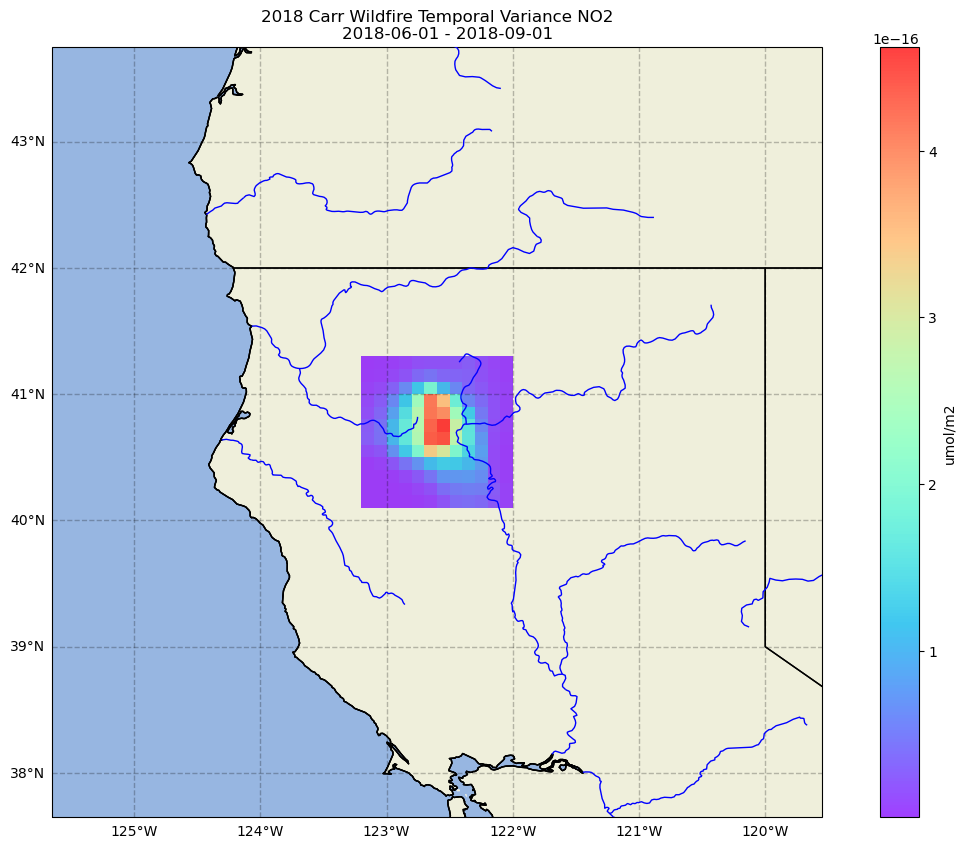

In [26]:
carr_temp_var_NO2 = ideas_processing.temporal_variance(aq_base_url, 'wustl-0.1degx0.1deg-daily-ca-SpeciesConc_NO2_D0', carr_bb, carr_start_time, carr_end_time)
carr_variance_title = f'2018 Carr Wildfire Temporal Variance NO2\n\
    {str(carr_start_time)[:10]} - {str(carr_end_time)[:10]}'
plotting.map_data(carr_temp_var_NO2, carr_variance_title, cb_label=units['NO2'])

### O3 Levels

#### O3 Spatial Mean

url
 https://ideas-digitaltwin.jpl.nasa.gov/nexus//timeSeriesSpark?ds=wustl-0.1degx0.1deg-daily-ca-SpeciesConc_O3_D0&minLon=-123.2&minLat=40.1&maxLon=-122&maxLat=41.3&startTime=2018-06-01T00:00:00Z&endTime=2018-09-01T00:00:00Z&lowPassFilter=False

Waiting for response from IDEAS...took 0.45187745802104473 seconds


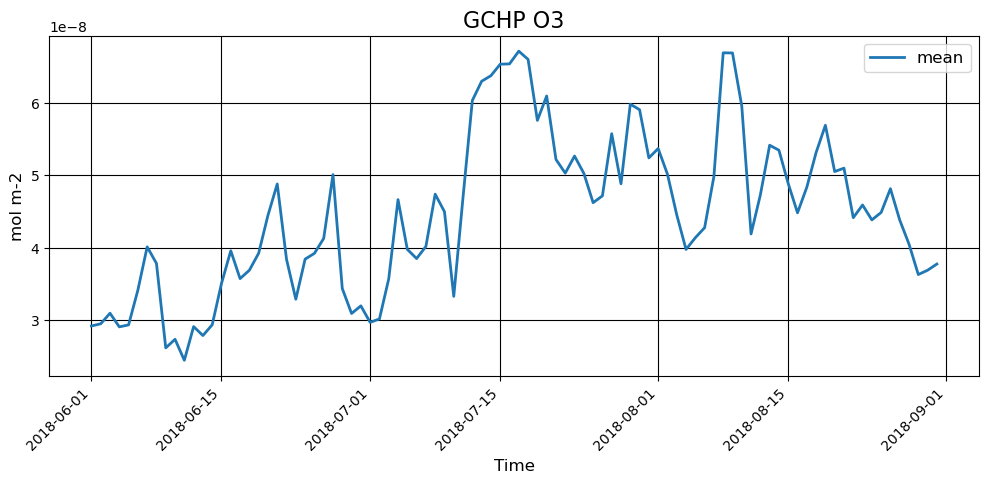

In [27]:
carr_O3 = ideas_processing.spatial_timeseries(aq_base_url, 'wustl-0.1degx0.1deg-daily-ca-SpeciesConc_O3_D0', carr_bb, carr_start_time, carr_end_time)
plotting.timeseries_plot([(carr_O3['mean'], 'mean')], 'Time', units['O3'], 'GCHP O3')

#### O3 Temporal Variance

url
 https://ideas-digitaltwin.jpl.nasa.gov/nexus//varianceSpark?ds=wustl-0.1degx0.1deg-daily-ca-SpeciesConc_O3_D0&minLon=-123.2&minLat=40.1&maxLon=-122&maxLat=41.3&startTime=2018-06-01T00:00:00Z&endTime=2018-09-01T00:00:00Z

Waiting for response from IDEAS... took 1.0123878750018775 seconds


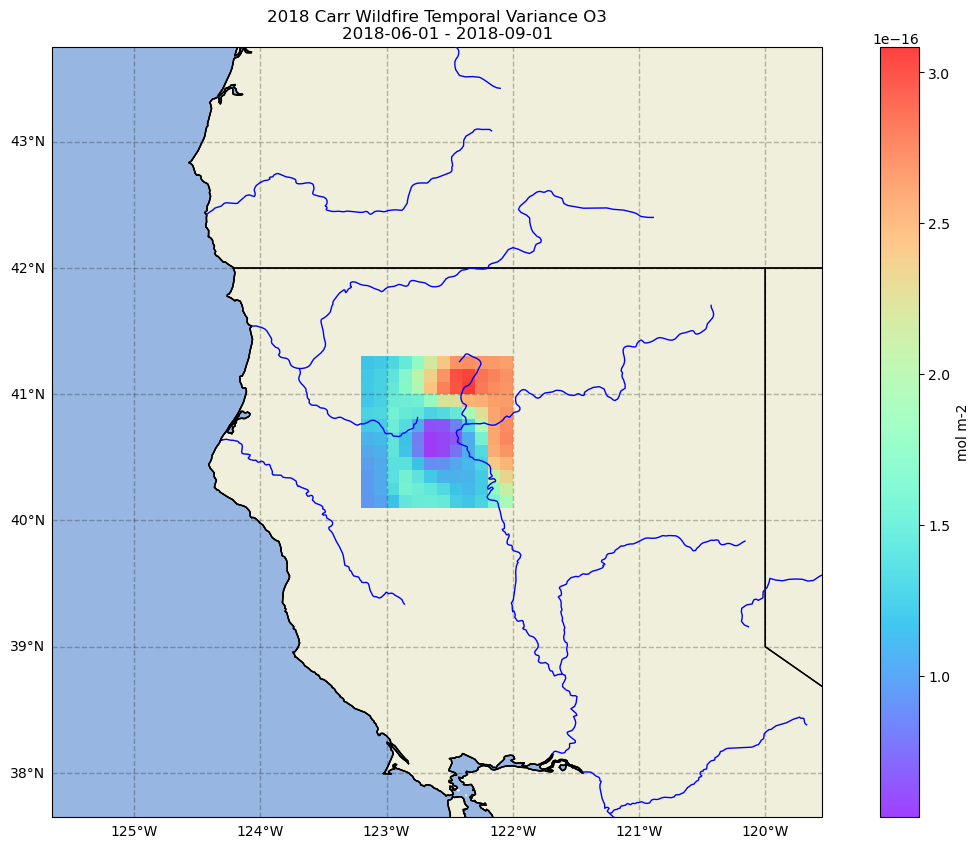

In [28]:
carr_temp_var_O3 = ideas_processing.temporal_variance(aq_base_url, 'wustl-0.1degx0.1deg-daily-ca-SpeciesConc_O3_D0', carr_bb, carr_start_time, carr_end_time)
carr_variance_title = f'2018 Carr Wildfire Temporal Variance O3\n\
    {str(carr_start_time)[:10]} - {str(carr_end_time)[:10]}'
plotting.map_data(carr_temp_var_O3, carr_variance_title, cb_label=units['O3'])

# Los Angeles ports backlog Fall 2021
Beginning around October 2021, the Ports of Los Angeles and Long Beach started suffering serious backlogs of ships due a surge in e-commerence because of the COVID-19 pandemic. This resulted in many ships anchored in the ports and releasing high amounts of pollutants. 

### Area of interest

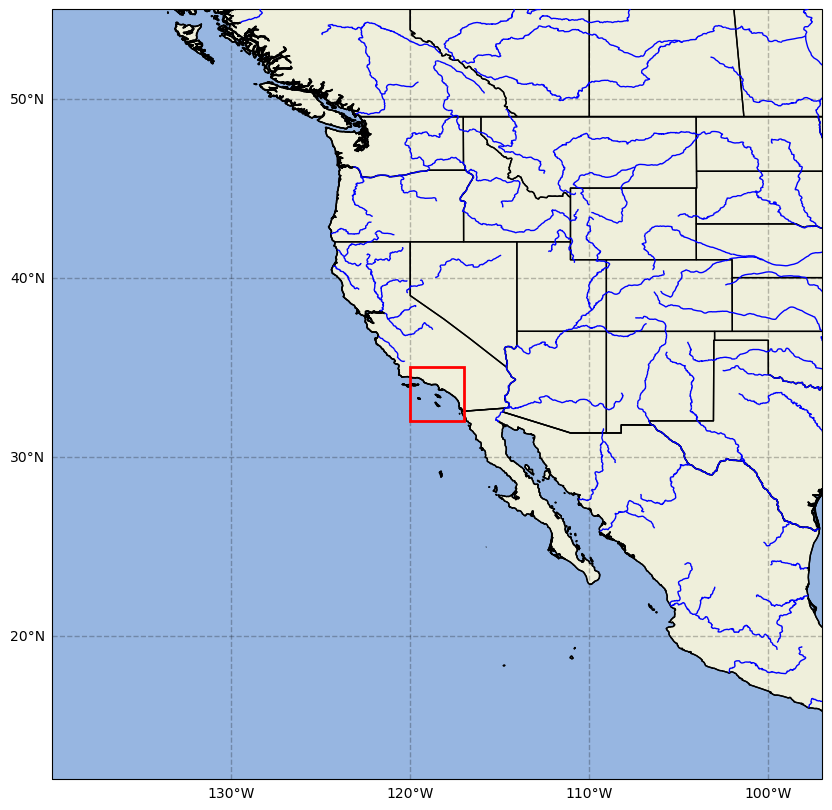

In [29]:
la_ports_bb = {
    'min_lon': -120,
    'max_lon': -117,
    'min_lat': 32,
    'max_lat': 35
}
la_ports_basemap_range = {
    'llcrnrlon': -140,
    'llcrnrlat': 0,
    'urcrnrlon': -90,
    'urcrnrlat': 60
}

la_ports_start_time = datetime(2021,10,1)
la_ports_end_time = datetime(2021,12,31)

la_ports_bbox = box(la_ports_bb['min_lon'], la_ports_bb['min_lat'], la_ports_bb['max_lon'], la_ports_bb['max_lat'])
plotting.map_box(la_ports_bb)

### SO2 Levels

#### SO2 Spatial Mean

url
 https://ideas-digitaltwin.jpl.nasa.gov/nexus//timeSeriesSpark?ds=TROPOMI-0.1deg-CA-SO2&minLon=-120&minLat=32&maxLon=-117&maxLat=35&startTime=2021-10-01T00:00:00Z&endTime=2021-12-31T00:00:00Z&lowPassFilter=False

Waiting for response from IDEAS...took 0.3362724999897182 seconds


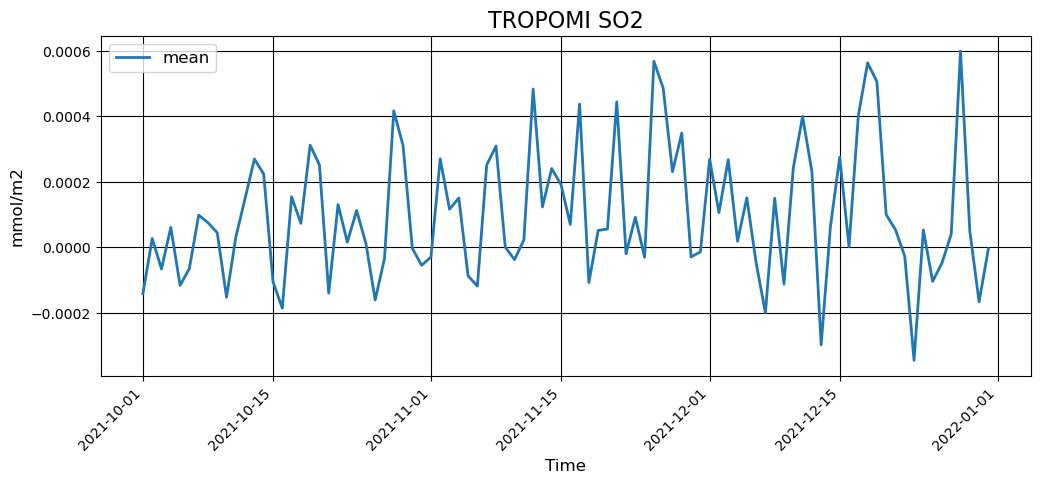

In [30]:
la_ports_tropomi_so2 = ideas_processing.spatial_timeseries(aq_base_url, SO2_dataset, la_ports_bb, la_ports_start_time, la_ports_end_time)
plotting.timeseries_plot([(la_ports_tropomi_so2['mean'], 'mean')], 'Time', units['SO2'], 'TROPOMI SO2')

#### SO2 Daily Difference

url
 https://ideas-digitaltwin.jpl.nasa.gov/nexus//dailydifferenceaverage_spark?dataset=TROPOMI-0.1deg-CA-SO2&climatology=TROPOMI-0.1deg-CA-SO2_clim&b=-120,32,-117,35&startTime=2021-10-01T00:00:00Z&endTime=2021-12-31T00:00:00Z

Waiting for response from IDEAS... took 5.351903542003129 seconds


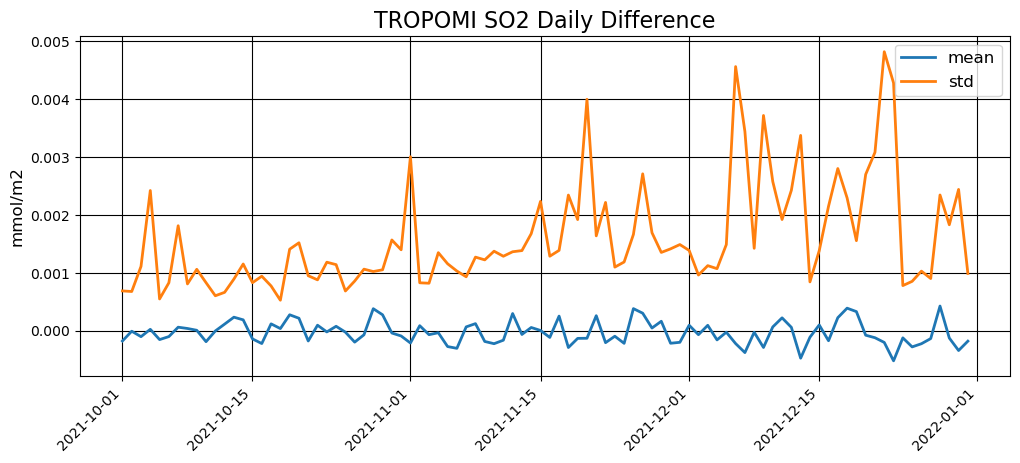

In [31]:
la_ports_SO2_daily_diff_data = ideas_processing.daily_diff(aq_base_url, SO2_dataset, SO2_computed_climatology, la_ports_bb, la_ports_start_time, la_ports_end_time)
plotting.timeseries_plot([(la_ports_SO2_daily_diff_data['mean'], 'mean'), (la_ports_SO2_daily_diff_data['std'], 'std')], '', 'mmol/m2', title='TROPOMI SO2 Daily Difference')

### O3 Levels

#### O3 Spatial Mean

url
 https://ideas-digitaltwin.jpl.nasa.gov/nexus//timeSeriesSpark?ds=TROPOMI-0.1deg-CA-O3&minLon=-120&minLat=32&maxLon=-117&maxLat=35&startTime=2021-10-01T00:00:00Z&endTime=2021-12-31T00:00:00Z&lowPassFilter=False

Waiting for response from IDEAS...took 0.8801048340392299 seconds


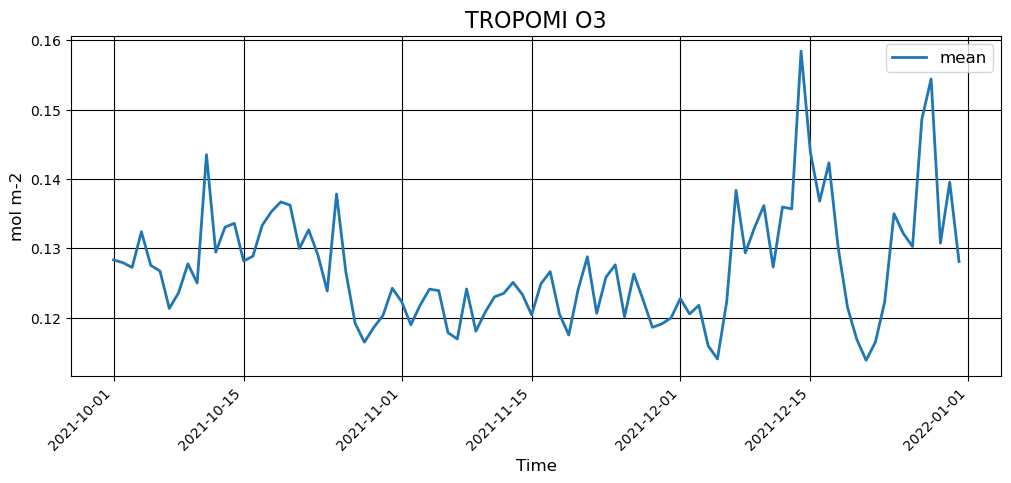

In [32]:
tropomi_o3 = ideas_processing.spatial_timeseries(aq_base_url, O3_dataset, la_ports_bb, la_ports_start_time, la_ports_end_time)
plotting.timeseries_plot([(tropomi_o3['mean'], 'mean')], 'Time', units['O3'], 'TROPOMI O3')

#### O3 Daily Difference

url
 https://ideas-digitaltwin.jpl.nasa.gov/nexus//dailydifferenceaverage_spark?dataset=TROPOMI-0.1deg-CA-O3&climatology=TROPOMI-0.1deg-CA-O3_clim&b=-120,32,-117,35&startTime=2021-10-01T00:00:00Z&endTime=2021-12-31T00:00:00Z

Waiting for response from IDEAS... took 2.8739135839859955 seconds


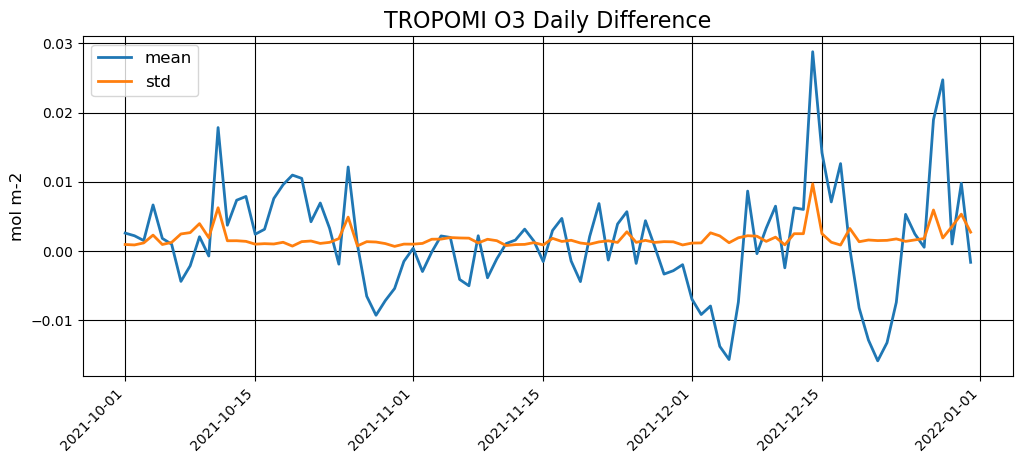

In [33]:
la_ports_O3_daily_diff_data = ideas_processing.daily_diff(aq_base_url, O3_dataset, O3_computed_climatology, la_ports_bb, la_ports_start_time, la_ports_end_time)
plotting.timeseries_plot([(la_ports_O3_daily_diff_data['mean'], 'mean'), (la_ports_O3_daily_diff_data['std'], 'std')], '', 'mol m-2', title='TROPOMI O3 Daily Difference')

### NO2 Levels

#### NO2 Spatial Mean

url
 https://ideas-digitaltwin.jpl.nasa.gov/nexus//timeSeriesSpark?ds=TROPOMI-0.1deg-CA-NO2&minLon=-120&minLat=32&maxLon=-117&maxLat=35&startTime=2021-10-01T00:00:00Z&endTime=2021-12-31T00:00:00Z&lowPassFilter=False

Waiting for response from IDEAS...took 0.3175635419902392 seconds


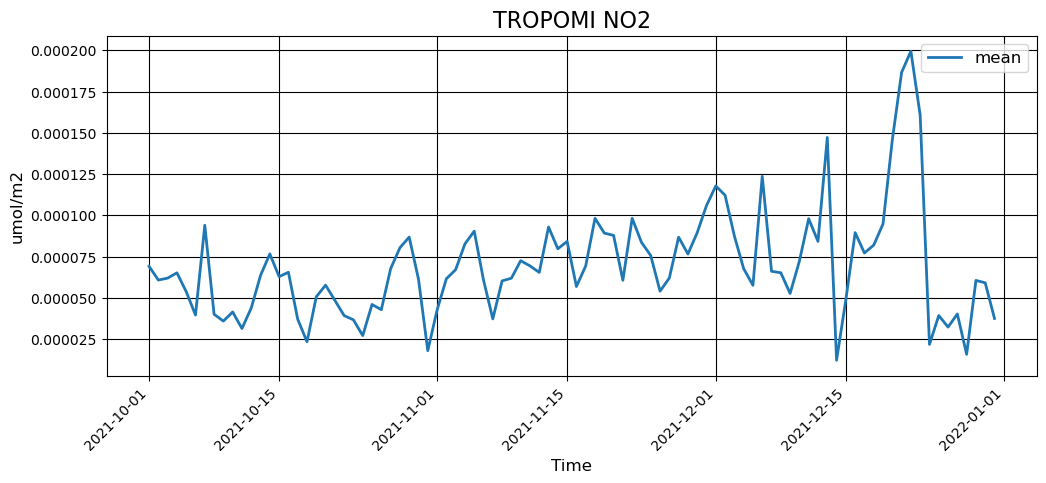

In [34]:
tropomi_no2 = ideas_processing.spatial_timeseries(aq_base_url, NO2_dataset, la_ports_bb, la_ports_start_time, la_ports_end_time)
plotting.timeseries_plot([(tropomi_no2['mean'], 'mean')], 'Time', units['NO2'], 'TROPOMI NO2')

#### NO2 Daily Difference

url
 https://ideas-digitaltwin.jpl.nasa.gov/nexus//dailydifferenceaverage_spark?dataset=TROPOMI-0.1deg-CA-NO2&climatology=TROPOMI-0.1deg-CA-NO2_clim&b=-120,32,-117,35&startTime=2021-10-01T00:00:00Z&endTime=2021-12-31T00:00:00Z

Waiting for response from IDEAS... took 1.2360783339827321 seconds


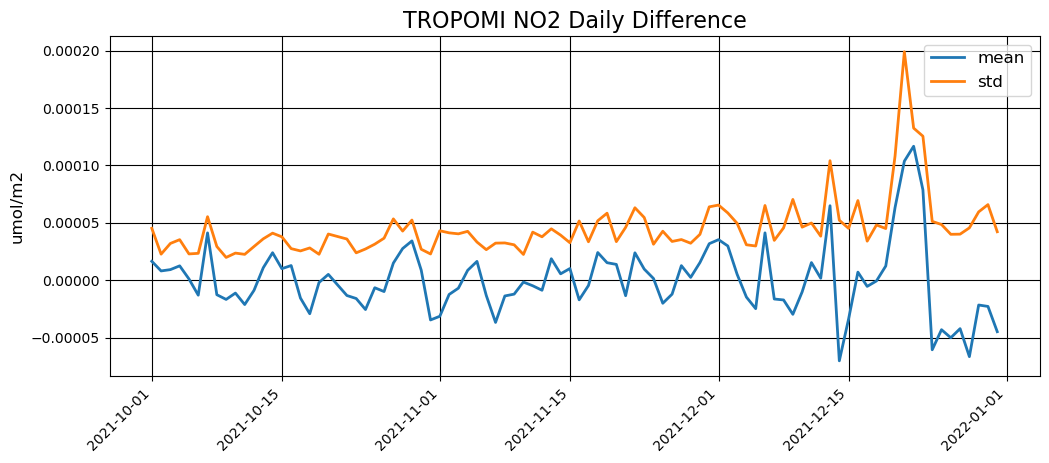

In [35]:
la_ports_NO2_daily_diff_data = ideas_processing.daily_diff(aq_base_url, NO2_dataset, NO2_computed_climatology, la_ports_bb, la_ports_start_time, la_ports_end_time)
plotting.timeseries_plot([(la_ports_NO2_daily_diff_data['mean'], 'mean'), (la_ports_NO2_daily_diff_data['std'], 'std')], '', 'umol/m2', title='TROPOMI NO2 Daily Difference')

#### NO2 Latitude Hovmöller

url
 https://ideas-digitaltwin.jpl.nasa.gov/nexus//latitudeTimeHofMoellerSpark?ds=TROPOMI-0.1deg-CA-NO2&b=-120,32,-117,35&startTime=2021-10-01T00:00:00Z&endTime=2021-12-31T00:00:00Z

Waiting for response from IDEAS... took 1.1202156660147011 seconds


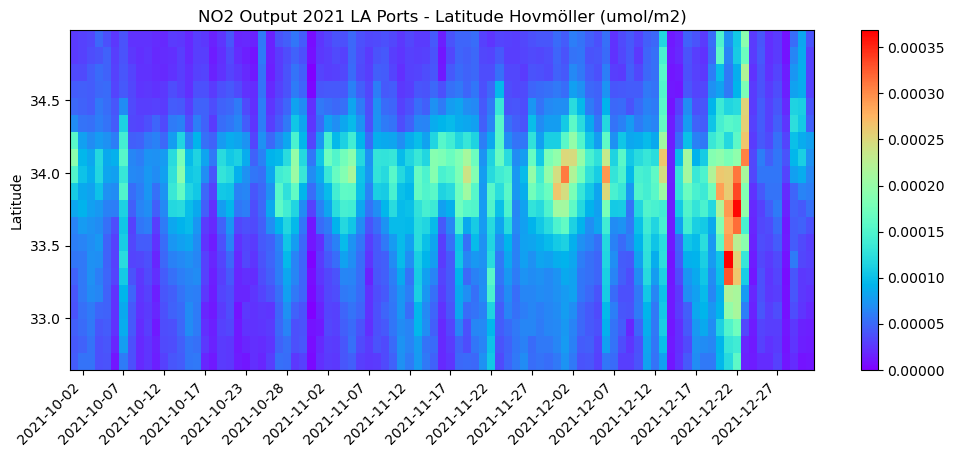

In [36]:
la_ports_parameters = (aq_base_url, NO2_dataset, la_ports_bb, la_ports_start_time, la_ports_end_time)
la_ports_lat_hov = ideas_processing.hofmoeller(*la_ports_parameters, dim='latitude')

la_ports_hov_title = 'NO2 Output 2021 LA Ports - Latitude Hovmöller (umol/m2)'
plotting.heatmap(la_ports_lat_hov['mean'].transpose(), '', 'Latitude', la_ports_hov_title)

#### NO2 Longitude Hovmöller

url
 https://ideas-digitaltwin.jpl.nasa.gov/nexus//longitudeTimeHofMoellerSpark?ds=TROPOMI-0.1deg-CA-NO2&b=-120,32,-117,35&startTime=2021-10-01T00:00:00Z&endTime=2021-12-31T00:00:00Z

Waiting for response from IDEAS... took 1.011450874968432 seconds


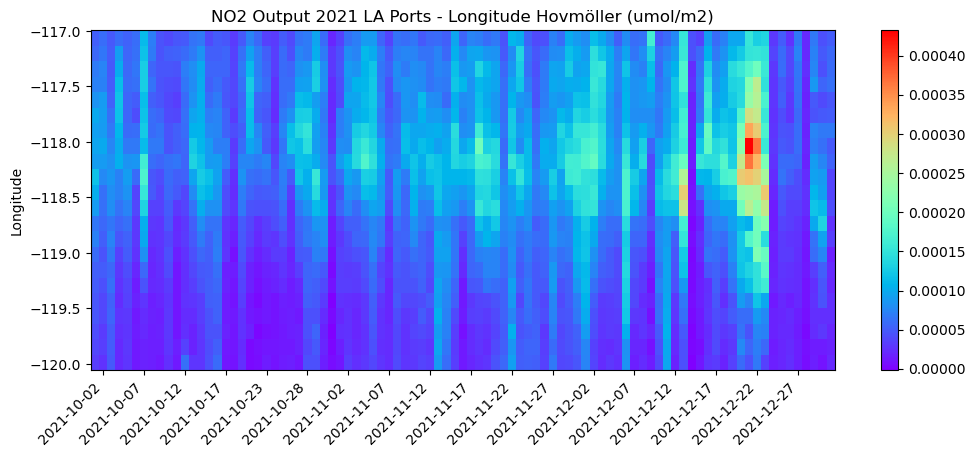

In [37]:
la_ports_parameters = (aq_base_url, NO2_dataset, la_ports_bb, la_ports_start_time, la_ports_end_time)
la_ports_lon_hov = ideas_processing.hofmoeller(*la_ports_parameters, dim='longitude')

la_ports_hov_title = 'NO2 Output 2021 LA Ports - Longitude Hovmöller (umol/m2)'
plotting.heatmap(la_ports_lon_hov['mean'].transpose(), '', 'Longitude', la_ports_hov_title)

### CO Levels

#### CO Spatial Mean

url
 https://ideas-digitaltwin.jpl.nasa.gov/nexus//timeSeriesSpark?ds=TROPOMI-0.1deg-CA-CO&minLon=-120&minLat=32&maxLon=-117&maxLat=35&startTime=2021-10-01T00:00:00Z&endTime=2021-12-31T00:00:00Z&lowPassFilter=False

Waiting for response from IDEAS...took 0.3797074999893084 seconds


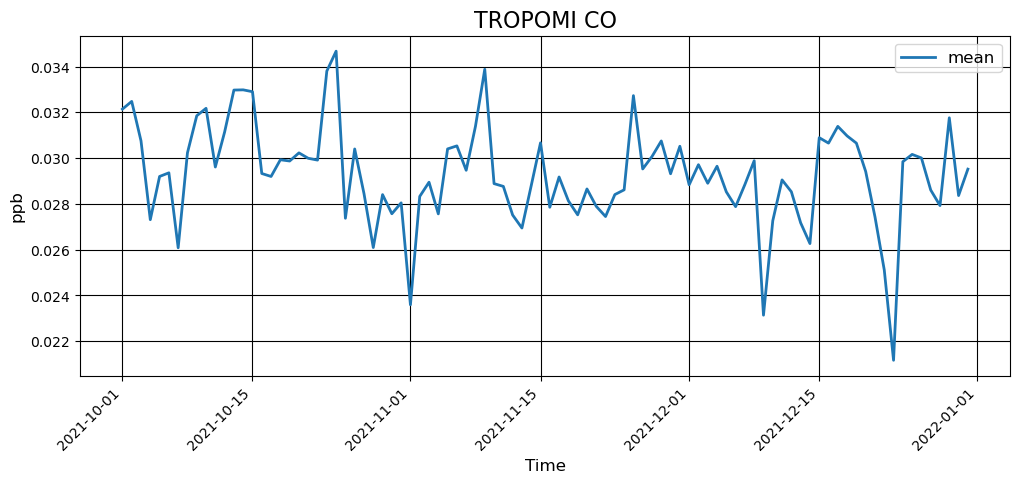

In [38]:
tropomi_co = ideas_processing.spatial_timeseries(aq_base_url, CO_dataset, la_ports_bb, la_ports_start_time, la_ports_end_time)
plotting.timeseries_plot([(tropomi_co['mean'], 'mean')], 'Time', units['CO'], 'TROPOMI CO')

#### CO Daily Difference

url
 https://ideas-digitaltwin.jpl.nasa.gov/nexus//dailydifferenceaverage_spark?dataset=TROPOMI-0.1deg-CA-CO&climatology=TROPOMI-0.1deg-CA-CO_clim&b=-120,32,-117,35&startTime=2021-10-01T00:00:00Z&endTime=2021-12-31T00:00:00Z

Waiting for response from IDEAS... took 1.3071911669685505 seconds


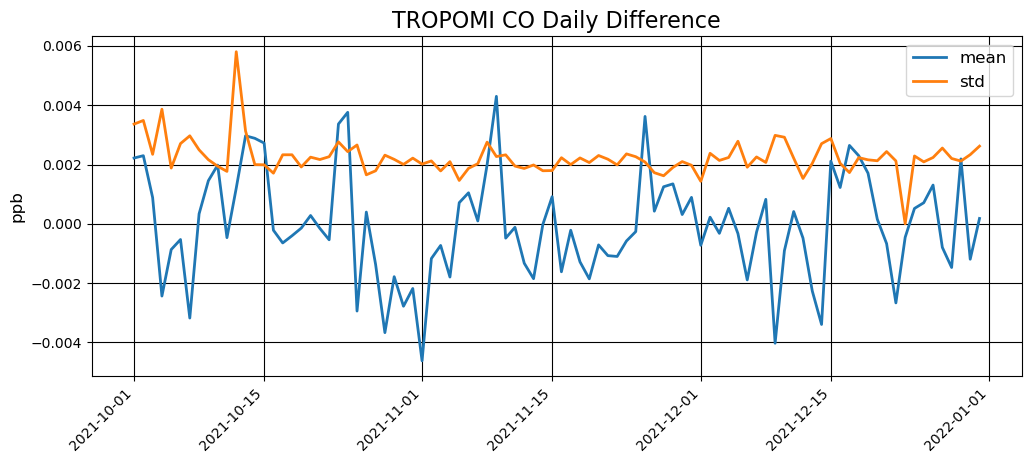

In [39]:
la_ports_CO_daily_diff_data = ideas_processing.daily_diff(aq_base_url, CO_dataset, CO_computed_climatology, la_ports_bb, la_ports_start_time, la_ports_end_time)
plotting.timeseries_plot([(la_ports_CO_daily_diff_data['mean'], 'mean'), (la_ports_CO_daily_diff_data['std'], 'std')], '', 'ppb', title='TROPOMI CO Daily Difference')

### CH4 Levels

Ships use methane (CH4) in the form of liquified natural gas. Remote marine air-quality measurements have shown significant methane emissions from ships using liquefied natural gas as a fuel.

#### CH4 Spatial Mean

url
 https://ideas-digitaltwin.jpl.nasa.gov/nexus//timeSeriesSpark?ds=TROPOMI-0.1deg-CA-CH4&minLon=-120&minLat=32&maxLon=-117&maxLat=35&startTime=2021-10-01T00:00:00Z&endTime=2021-12-31T00:00:00Z&lowPassFilter=False

Waiting for response from IDEAS...took 0.3446458749822341 seconds


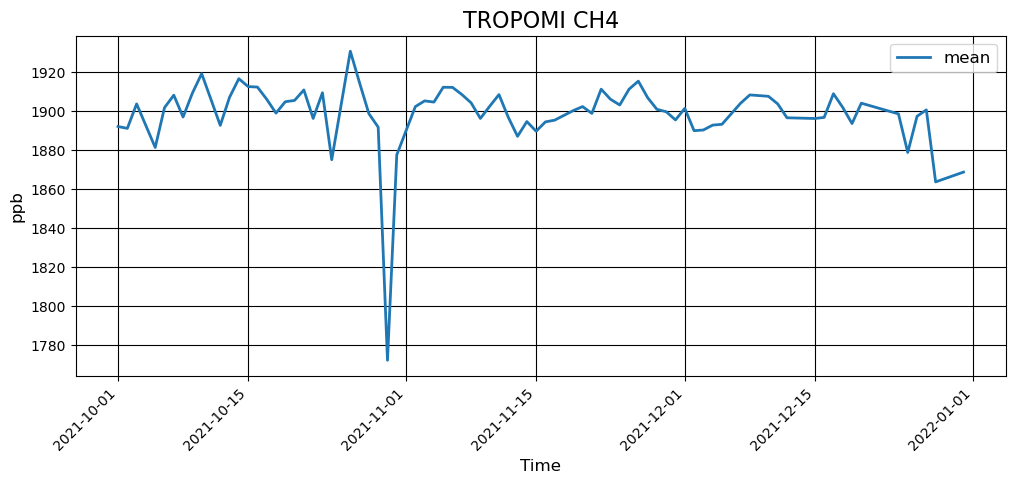

In [40]:
tropomi_ch4 = ideas_processing.spatial_timeseries(aq_base_url, CH4_dataset, la_ports_bb, la_ports_start_time, la_ports_end_time)
plotting.timeseries_plot([(tropomi_ch4['mean'], 'mean')], 'Time', units['CH4'], 'TROPOMI CH4')

#### CH4 Daily Difference

url
 https://ideas-digitaltwin.jpl.nasa.gov/nexus//dailydifferenceaverage_spark?dataset=TROPOMI-0.1deg-CA-CH4&climatology=TROPOMI-0.1deg-CA-CH4_clim&b=-120,32,-117,35&startTime=2021-10-01T00:00:00Z&endTime=2021-12-31T00:00:00Z

Waiting for response from IDEAS... took 1.3692300830152817 seconds


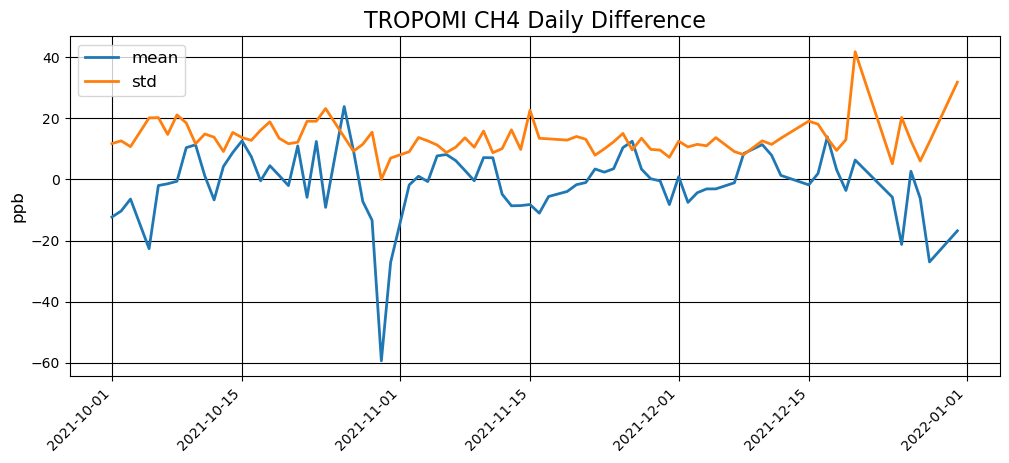

In [41]:
la_ports_CH4_daily_diff_data = ideas_processing.daily_diff(aq_base_url, CH4_dataset, CH4_computed_climatology, la_ports_bb, la_ports_start_time, la_ports_end_time)
plotting.timeseries_plot([(la_ports_CH4_daily_diff_data['mean'], 'mean'), (la_ports_CH4_daily_diff_data['std'], 'std')], '', 'ppb', title='TROPOMI CH4 Daily Difference')

# Fireworks during 4th of July 2022 in Los Angeles County
Despite fireworks being outlawed for personal use in Los Angeles County, there is a significant amount of illegal fireworks displays in the area around 4th of July that cause very smoggy conditions.  
Below we model our in situ Particulate matter 2.5 and Black Carbon data from around 4th of July 

### Area of Interest

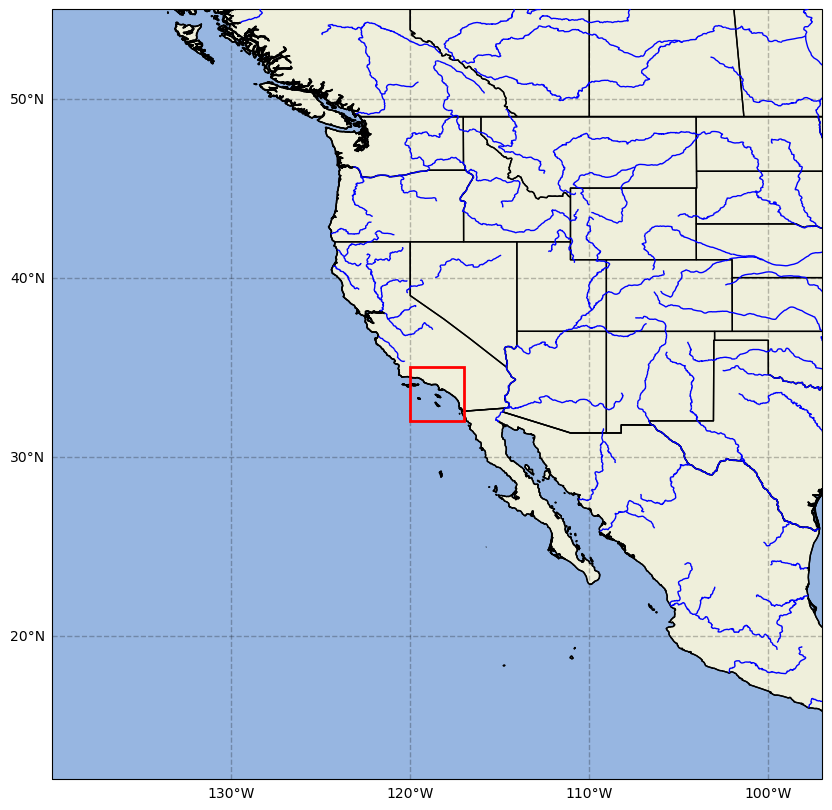

In [42]:
la_ports_bbox = box(la_ports_bb['min_lon'], la_ports_bb['min_lat'], la_ports_bb['max_lon'], la_ports_bb['max_lat'])
plotting.map_box(la_ports_bb)

### Get PM 2.5 and Black Carbon (BC) from B301 GRIMM Aethalometer (2021-06-28 to 2021-07-11)

In [43]:
start_time_fireworks      = datetime(2021,6,28)
end_time_fireworks        = datetime(2021,7,11)
bb_string_fireworks       = '-120,30,-115,40'
provider_fireworks        = 'B301-GRIMM-Aethalometer'

pm25_bc_2021_fireworks = ideas_processing.insitu(aq_base_url, provider_fireworks, 'AQACF', 
                                                 bb_string_fireworks, start_time_fireworks, 
                                                 end_time_fireworks, 'pm2_5')
pm25_bc_2021_fireworks 

https://ideas-digitaltwin.jpl.nasa.gov//insitu/1.0/query_data_doms_custom_pagination?startIndex=0&itemsPerPage=10000&provider=B301-GRIMM-Aethalometer&project=AQACF&startTime=2021-06-28T00:00:00Z&endTime=2021-07-11T00:00:00Z&bbox=-120,30,-115,40&variable=pm2_5
http://ideas-digitaltwin.jpl.nasa.gov/insitu/1.0/query_data_doms_custom_pagination?startIndex=0&itemsPerPage=10000&provider=B301-GRIMM-Aethalometer&project=AQACF&startTime=2021-06-28T00:00:00Z&endTime=2021-07-11T00:00:00Z&bbox=-120,30,-115,40&variable=pm2_5&markerTime=2021-07-11T00:00:00Z&markerPlatform=89c98e3c4f89051c23b19ce09ebce394065f7cf464b67571d2a2d1ed0efb56b9


provider project                  time  latitude  \
0    B301-GRIMM-Aethalometer   AQACF  2021-06-28T00:00:00Z   34.2013   
1    B301-GRIMM-Aethalometer   AQACF  2021-06-28T01:00:00Z   34.2013   
2    B301-GRIMM-Aethalometer   AQACF  2021-06-28T02:00:00Z   34.2013   
3    B301-GRIMM-Aethalometer   AQACF  2021-06-28T03:00:00Z   34.2013   
4    B301-GRIMM-Aethalometer   AQACF  2021-06-28T04:00:00Z   34.2013   
..                       ...     ...                   ...       ...   
306  B301-GRIMM-Aethalometer   AQACF  2021-07-10T21:00:00Z   34.2013   
307  B301-GRIMM-Aethalometer   AQACF  2021-07-10T22:00:00Z   34.2013   
308  B301-GRIMM-Aethalometer   AQACF  2021-07-10T23:00:00Z   34.2013   
309  B301-GRIMM-Aethalometer   AQACF  2021-07-11T00:00:00Z   34.2013   
310  B301-GRIMM-Aethalometer   AQACF  2021-07-11T00:00:00Z   34.2013   

     longitude  site      pm2_5        bc   no2    co  ...  \
0    -118.1714  None  11.362640  0.757350  None  None  ...   
1    -118.1714  None  14.981810  0.713367  None  None  ...   
2    -118.1714  None  15.210835  0.805733  None  None  ...   
3    -118.1714  None  15.090975  0.844900  None  None  ...   
4    -118.1714  None  13.934720  0.793133  None  None  ...   
..         ...   ...        ...       ...   ...   ...  ...   
306  -118.1714  None  10.899160  0.801967  None  None  ...   
307  -118.1714  None  11.520140  0.916000  None  None  ...   
308  -118.1714  None  11.639300  0.823983  None  None  ...   
309  -118.1714  None  11.430140  0.848750  None  None  ...   
310  -118.1714  None  11.430140  0.848750  None  None  ...   

    Specific_conductance_quality Turbidity_quality  \
0                           None              None   
1                           None              None   
2                           None              None   
3                           None              None   
4                           None              None   
..                           ...               ...   
306                         None              None   
307                         None              None   
308                         None              None   
309                         None              None   
310                         None              None   

    Suspended_sediment_concentration_quality Precipitation_quality  \
0                                       None                  None   
1                                       None                  None   
2                                       None                  None   
3                                       None                  None   
4                                       None                  None   
..                                       ...                   ...   
306                                     None                  None   
307                                     None                  None   
308                                     None                  None   
309                                     None                  None   
310                                     None                  None   

    Depth_to_water_level_quality vortex_height vortex_avg_speed  \
0                           None          None             None   
1                           None          None             None   
2                           None          None             None   
3                           None          None             None   
4                           None          None             None   
..                           ...           ...              ...   
306                         None          None             None   
307                         None          None             None   
308                         None          None             None   
309                         None          None             None   
310                         None          None             None   

    vortex_height_rise_speed vortex_rain                                job_id  
0                       None      

### Get PM 2.5 and Black Carbon (BC) from B301 GRIMM Aethalometer (2022-06-28 to 2022-07-11)

In [44]:
start_time_fireworks      = datetime(2022,6,28)
end_time_fireworks        = datetime(2022,7,11)

pm25_bc_2022_fireworks = ideas_processing.insitu(aq_base_url, provider_fireworks, 'AQACF', 
                                                 bb_string_fireworks, start_time_fireworks, 
                                                 end_time_fireworks, 'pm2_5')
pm25_bc_2022_fireworks 

https://ideas-digitaltwin.jpl.nasa.gov//insitu/1.0/query_data_doms_custom_pagination?startIndex=0&itemsPerPage=10000&provider=B301-GRIMM-Aethalometer&project=AQACF&startTime=2022-06-28T00:00:00Z&endTime=2022-07-11T00:00:00Z&bbox=-120,30,-115,40&variable=pm2_5
http://ideas-digitaltwin.jpl.nasa.gov/insitu/1.0/query_data_doms_custom_pagination?startIndex=0&itemsPerPage=10000&provider=B301-GRIMM-Aethalometer&project=AQACF&startTime=2022-06-28T00:00:00Z&endTime=2022-07-11T00:00:00Z&bbox=-120,30,-115,40&variable=pm2_5&markerTime=2022-07-06T11:00:00Z&markerPlatform=162dd5df2e440d1009af7276863ae6fadfc88186359645be60ce38bc4b3b7c4a


provider project                  time  latitude  \
0    B301-GRIMM-Aethalometer   AQACF  2022-06-28T00:00:00Z   34.2013   
1    B301-GRIMM-Aethalometer   AQACF  2022-06-28T01:00:00Z   34.2013   
2    B301-GRIMM-Aethalometer   AQACF  2022-06-28T02:00:00Z   34.2013   
3    B301-GRIMM-Aethalometer   AQACF  2022-06-28T03:00:00Z   34.2013   
4    B301-GRIMM-Aethalometer   AQACF  2022-06-28T04:00:00Z   34.2013   
..                       ...     ...                   ...       ...   
200  B301-GRIMM-Aethalometer   AQACF  2022-07-06T08:00:00Z   34.2013   
201  B301-GRIMM-Aethalometer   AQACF  2022-07-06T09:00:00Z   34.2013   
202  B301-GRIMM-Aethalometer   AQACF  2022-07-06T10:00:00Z   34.2013   
203  B301-GRIMM-Aethalometer   AQACF  2022-07-06T11:00:00Z   34.2013   
204  B301-GRIMM-Aethalometer   AQACF  2022-07-06T11:00:00Z   34.2013   

     longitude  site      pm2_5        bc   no2    co  ...  \
0    -118.1714  None  11.296105  0.589517  None  None  ...   
1    -118.1714  None  10.009993  0.516750  None  None  ...   
2    -118.1714  None   8.843898  0.445650  None  None  ...   
3    -118.1714  None   8.405561  0.423650  None  None  ...   
4    -118.1714  None   7.942223  0.444567  None  None  ...   
..         ...   ...        ...       ...   ...   ...  ...   
200  -118.1714  None  13.312225  0.518117  None  None  ...   
201  -118.1714  None  14.277790  1.410283  None  None  ...   
202  -118.1714  None  12.637220  0.891233  None  None  ...   
203  -118.1714  None  11.040000  0.653933  None  None  ...   
204  -118.1714  None  11.040000  0.653933  None  None  ...   

    Specific_conductance_quality Turbidity_quality  \
0                           None              None   
1                           None              None   
2                           None              None   
3                           None              None   
4                           None              None   
..                           ...               ...   
200                         None              None   
201                         None              None   
202                         None              None   
203                         None              None   
204                         None              None   

    Suspended_sediment_concentration_quality Precipitation_quality  \
0                                       None                  None   
1                                       None                  None   
2                                       None                  None   
3                                       None                  None   
4                                       None                  None   
..                                       ...                   ...   
200                                     None                  None   
201                                     None                  None   
202                                     None                  None   
203                                     None                  None   
204                                     None                  None   

    Depth_to_water_level_quality vortex_height vortex_avg_speed  \
0                           None          None             None   
1                           None          None             None   
2                           None          None             None   
3                           None          None             None   
4                           None          None             None   
..                           ...           ...              ...   
200                         None          None             None   
201                         None          None             None   
202                         None          None             None   
203                         None          None             None   
204                         None          None             None   

    vortex_height_rise_speed vortex_rain                                job_id  
0                       None      

## Compare 2021 and 2022 emissions 
Unlike last year, PM2.5 levels showed only a minor elevation during the night of July 4th. However, a large peak (up to 100 µg/m3) was observed during the morning of July 5th, comparable to the levels measured last year, most likely due to the transport of smoke from South/Central LA.

As expected, Black Carbon (BC) levels did not show an appreciable increase during the fireworks event. Fireworks do not emit very large amounts of BC relative to other species. Organic and inorganic aerosols (particularly metals) dominate emissions from fireworks. A PM2.5 sample was collected, using the Aerosol Mass and Optical Depth (AMOD) instrument, for chemical analysis which includes X-ray fluorescence (XRF) spectroscopy for detection of metals.

In [45]:
time_2021_fireworks = np.array(pm25_bc_2021_fireworks['time'])
pm25_2021_fireworks = np.array(pm25_bc_2021_fireworks['pm2_5'])
bc_2021_fireworks   = np.array(pm25_bc_2021_fireworks['bc'])

time_2022_fireworks = np.array(pm25_bc_2022_fireworks['time'])
pm25_2022_fireworks = np.array(pm25_bc_2022_fireworks['pm2_5'])
bc_2022_fireworks   = np.array(pm25_bc_2022_fireworks['bc'])

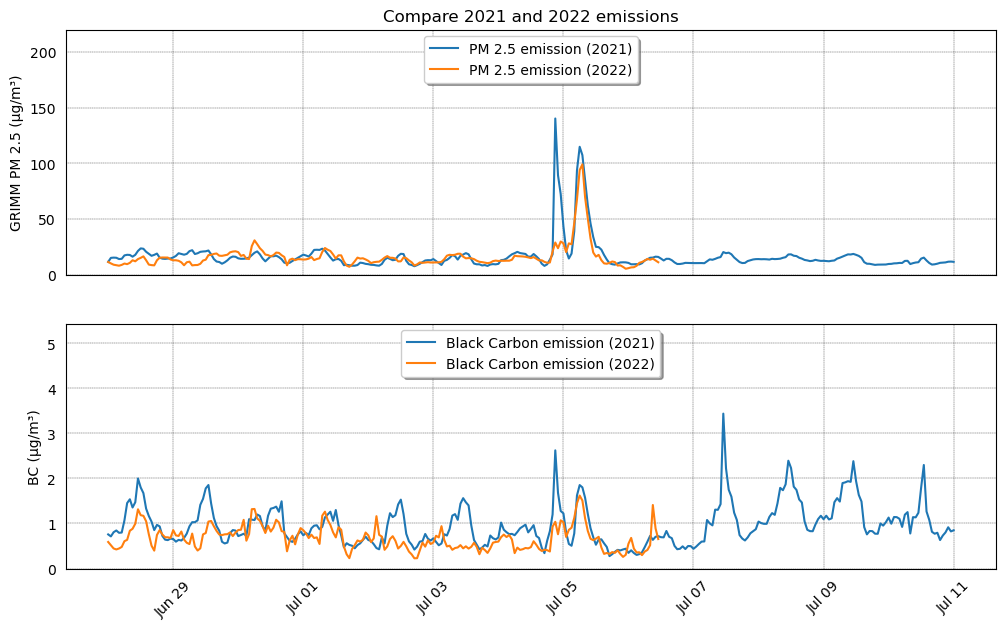

In [72]:
y_datas = [ pm25_2021_fireworks, pm25_2022_fireworks, bc_2021_fireworks, bc_2022_fireworks ]
x_datas = [ time_2021_fireworks, time_2022_fireworks, time_2021_fireworks, time_2022_fireworks ]
series_labels = [ 'PM 2.5 emission (2021)', 'PM 2.5 emission (2022)', 
                  'Black Carbon emission (2021)', 'Black Carbon emission (2022)' ]
y_labels = [ 'GRIMM PM 2.5 (µg/m³)', 'BC (µg/m³)' ]

plotting.stacked_overlay_plot(x_datas=x_datas, y_datas=y_datas, series_labels=series_labels,
                       y_labels=y_labels, title='Compare 2021 and 2022 emissions', top_paddings=[80, 2])

# Air Pollution in the Yellow Sea

The Yellow Sea is a marginal sea of the Western Pacific Ocean located between mainland China and the Korean Peninsula. It is considered among the most degraded marine areas on earth. Loss of natural coastal habitats due to land reclamation has resulted in the destruction of more than 60% of tidal wetlands around the Yellow Sea. 

Every year, China invokes sustainability to unilaterally impose a ban on fishing in the Yellow Sea, Bohai Sea, East China Sea, and the waters north of 12 degrees latitude in the South China Sea. This ban is in effect from May 1 to August 16 and is enforced by the Chinese Coast Guard.

China is one of the largest maritime states and has the largest fishery catch in the world. The large number of fishing vessels in the Yellow Sea has increased the air pollution. 

Pollution also tends to increase in the winter as an increased amount of fuel is burned.  Furthermore dense cold air traps pollutants near the surface of the earth which increases air pollution levels.

### Area of Interest

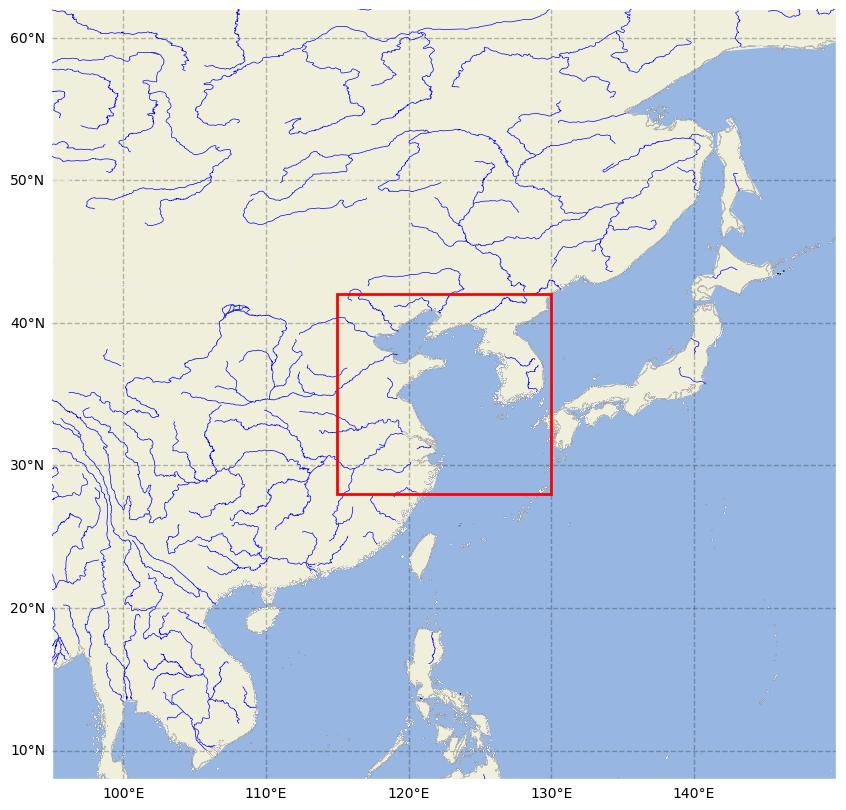

In [47]:
yellow_sea_bb = {'min_lon': 28, 'max_lon': 130, 'min_lat': 8, 'max_lat': 30}
yellow_sea_start_time = datetime(2020, 1, 1)
yellow_sea_end_time = datetime(2020, 12, 1)

yellow_sea_bb = {'min_lon': 115, 'max_lon': 130, 'min_lat': 28, 'max_lat': 42}
plotting.map_box(yellow_sea_bb)

### Air Quality: May vs. February in the Yellow Sea 

The below graphs are a visualization of Aerosol Optical Depth (AOD) data. Aerosol Optical Depth is the measure of aerosols (e.g., urban haze, smoke. particles, desert dust) distributed within a column of air. 


### Generate Legend

In [48]:
wmsUrl = 'https://gibs.earthdata.nasa.gov/wms/epsg4326/best/wms.cgi?\
SERVICE=WMS&REQUEST=GetCapabilities'

response = requests.get(wmsUrl)
WmsTree = xmlet.fromstring(response.content)

legendImg = None
for child in WmsTree.iter():
    for layer in child.findall("./{http://www.opengis.net/wms}Capability/{http://www.opengis.net/wms}Layer//*/"): 
         if layer.tag == '{http://www.opengis.net/wms}Layer': 
            f = layer.find("{http://www.opengis.net/wms}Name")
            if f is not None:
                if f.text == "MODIS_Combined_Value_Added_AOD":
                    # Style
                    e = layer.find(("{http://www.opengis.net/wms}Style/" +
                                    "{http://www.opengis.net/wms}LegendURL/" +
                                    "{http://www.opengis.net/wms}OnlineResource"))
                    legendURL = e.attrib["{http://www.w3.org/1999/xlink}href"]
                    combinedLegendImg = Image(url=legendURL)
                    
#display(combinedLegendImg)

### May (Summer & Fishing Moratorium)

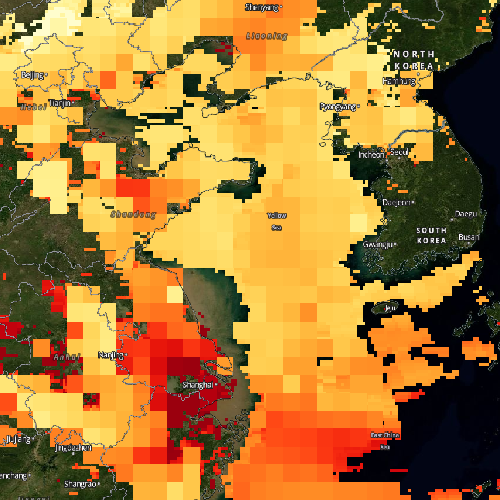

In [49]:
# Connect to GIBS WMS Service
wms = WebMapService('https://gibs.earthdata.nasa.gov/wms/epsg4326/best/wms.cgi?', version='1.3.0')

img = wms.getmap(layers=['BlueMarble_NextGeneration',
                         'MODIS_Terra_Aerosol', 
                         'MODIS_Aqua_Aerosol', 
                         'MODIS_Combined_Value_Added_AOD',
                         'Reference_Features',
                         'Reference_Labels'],  # Layers
                 srs='epsg:4326',  # Map projection
                 bbox=(115, 28, 130, 42),  # Bounds (min-lon, min-lat, max-lon, max-lat) -> min lon: 115.179845, min lat: 28.087158,130.209142,41.718570
                 size=(500, 500),  # Image size
                 time='2021-05-02',  # Time of data
                 format='image/png',  # Image format
                 transparent=True)  # Nodata transparency

# View image and legend
display(combinedLegendImg)
Image(img.read())

### February (Winter & Fishing Season)

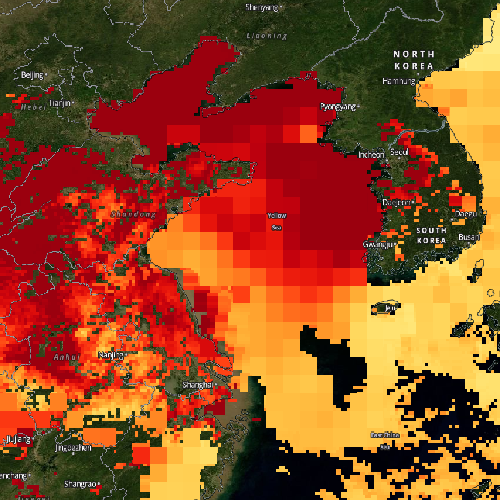

In [50]:
# Connect to GIBS WMS Service
wms = WebMapService('https://gibs.earthdata.nasa.gov/wms/epsg4326/best/wms.cgi?', version='1.3.0')

img = wms.getmap(layers=['BlueMarble_NextGeneration',
                         'MODIS_Terra_Aerosol',
                         'MODIS_Aqua_Aerosol', 
                         'MODIS_Combined_Value_Added_AOD',
                         'Reference_Features',
                         'Reference_Labels'],  # Layers
                 srs='epsg:4326',  # Map projection
                 bbox=(115, 28, 130, 42),  # Bounds (min-lon, min-lat, max-lon, max-lat)
                 size=(500, 500),  # Image size
                 time='2022-02-25',  # Time of data
                 format='image/png',  # Image format
                 transparent=True)  # Nodata transparency

# View image and legend
display(combinedLegendImg)
Image(img.read())

### NO2 Levels

#### NO2 Spatial Mean

url
 https://ideas-digitaltwin.jpl.nasa.gov/nexus//timeSeriesSpark?ds=GMU-OMI-0.25deg-monthly-Global-NO2&minLon=115&minLat=28&maxLon=130&maxLat=42&startTime=2020-01-01T00:00:00Z&endTime=2020-12-01T00:00:00Z&lowPassFilter=False

Waiting for response from IDEAS...took 5.552678709034808 seconds


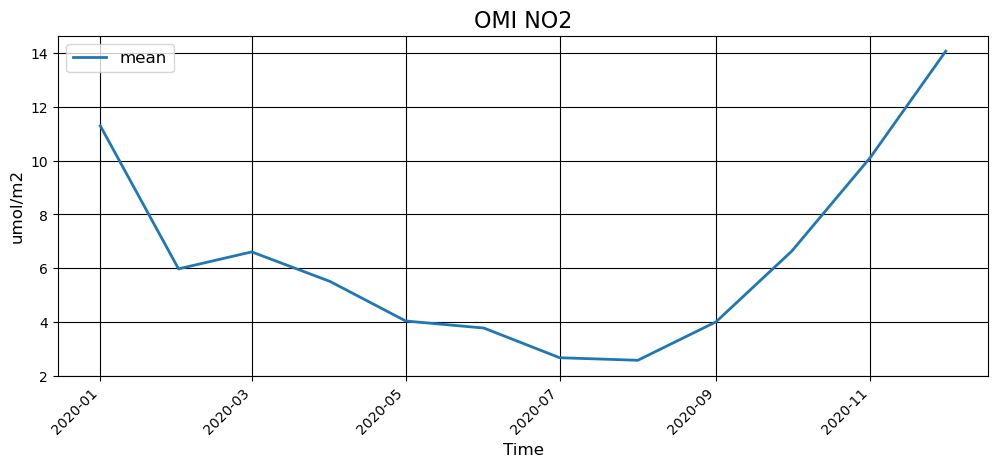

In [73]:
yellow_sea_omi_no2 = ideas_processing.spatial_timeseries(aq_base_url, 'GMU-OMI-0.25deg-monthly-Global-NO2', yellow_sea_bb, yellow_sea_start_time, yellow_sea_end_time)
plotting.timeseries_plot([(yellow_sea_omi_no2['mean'], 'mean')], 'Time', units['NO2'], 'OMI NO2')

# Fires and Thermal Anomalies in Southeast Asia (2022 Fire Season)
Fire season typically runs from February to April each year and is characterized by high temperatures, dry weather, and widespread agricultural burning.  

### Area of Interest

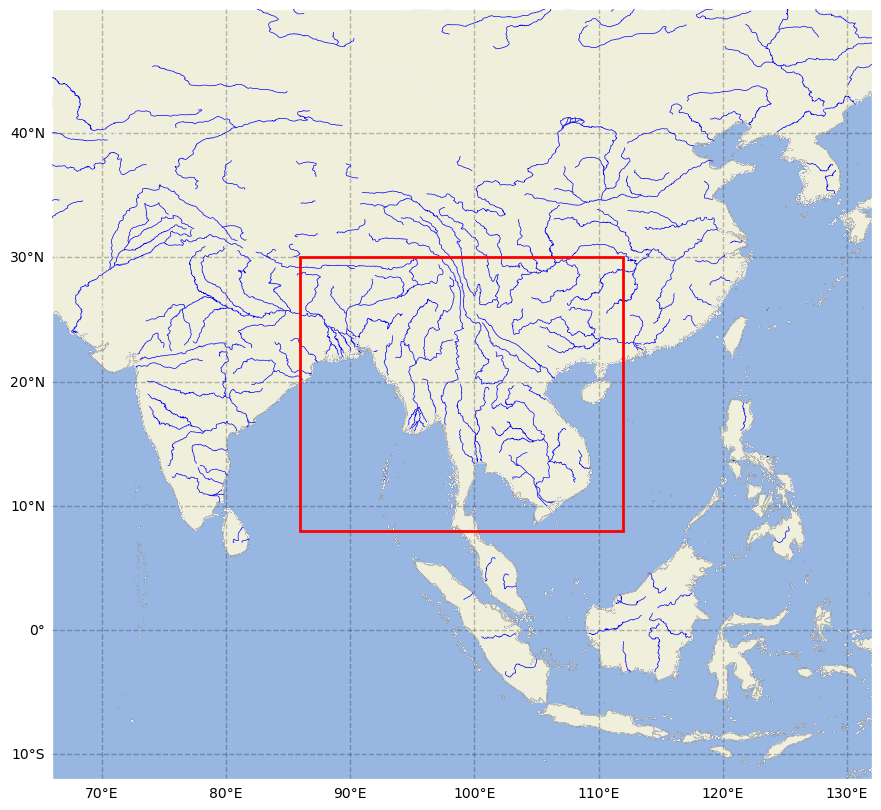

In [52]:
anomalies_start_time = datetime(2022, 2, 1)
anomalies_end_time = datetime(2022, 4, 30)
GMU_NO2_dataset = 'GMU-OMI-0.25deg-monthly-Global-NO2'
GMU_O3_dataset = 'GMU-OMI-0.25deg-monthly-Global-O3'

anomalies_bb = {'min_lon': 86, 'max_lon': 112, 'min_lat': 8, 'max_lat': 30}
plotting.map_box(anomalies_bb)

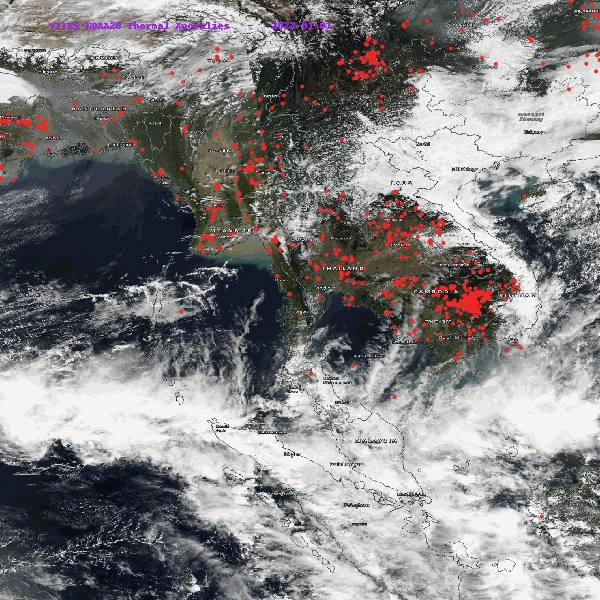

In [53]:
# Note: takes ~20s to generate
wms = WebMapService('https://gibs.earthdata.nasa.gov/wms/epsg4326/best/wms.cgi?', version='1.3.0')

layers=['VIIRS_NOAA20_CorrectedReflectance_TrueColor', 
        'VIIRS_NOAA20_Thermal_Anomalies_375m_All',
        'Reference_Features',
        'Reference_Labels']
color = 'rgb(160, 32, 240)'
frames = []

sdate = datetime(2022, 1, 1)
edate = datetime(2022, 4, 1)
dates = pd.date_range(sdate,edate,freq='MS') 

for day in dates:
    datatime = day.strftime("%Y-%m-%d")
    img = wms.getmap(layers=layers,  # Layers
                     srs='epsg:4326',  # Map projection
                     bbox=(86, -5, 112, 31), # Bounds
                     size=(600,600),  # Image size
                     time=datatime,  # Time of data
                     format='image/png',  # Image format
                     transparent=True)  # Nodata transparency

    image = I.open(img)
    draw = ImageDraw.Draw(image)
    (x, y) = (50, 20)
    draw.text((x, y), f'VIIRS NOAA20 Thermal Anomalies   -   {datatime}', fill=color)
    frames.append(image)
    
frames[0].save('VIIRS_NOAA20_Thermal_Anomalies_375m_All.gif',
               format='GIF',
               append_images=frames,
               save_all=True,
               duration=1000,
               loop=0)

Image('VIIRS_NOAA20_Thermal_Anomalies_375m_All.gif')

### NO2 Levels

#### NO2 Spatial Mean

url
 https://ideas-digitaltwin.jpl.nasa.gov/nexus//timeSeriesSpark?ds=GMU-OMI-0.25deg-monthly-Global-NO2&minLon=86&minLat=8&maxLon=112&maxLat=30&startTime=2022-01-01T00:00:00Z&endTime=2022-09-01T00:00:00Z&lowPassFilter=False

Waiting for response from IDEAS...took 1.961046583019197 seconds


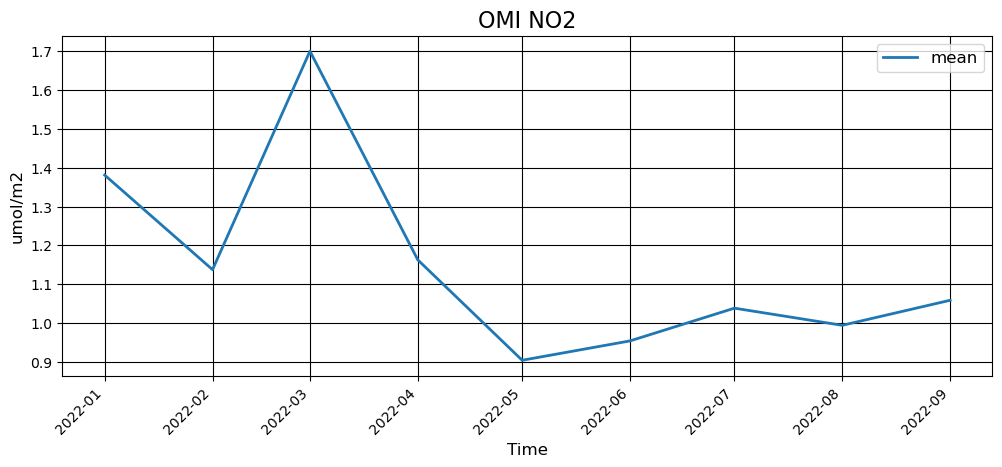

In [74]:
anomalies_NO2 = ideas_processing.spatial_timeseries(aq_base_url, GMU_NO2_dataset, anomalies_bb, datetime(2022, 1, 1), datetime(2022, 9, 1))
plotting.timeseries_plot([(anomalies_NO2['mean'], 'mean')], 'Time', units['NO2'], 'OMI NO2')

#### NO2 Temporal Mean

url
 https://ideas-digitaltwin.jpl.nasa.gov/nexus//timeAvgMapSpark?ds=GMU-OMI-0.25deg-monthly-Global-NO2&b=86,8,112,30&startTime=2022-02-01T00:00:00Z&endTime=2022-04-30T00:00:00Z

Waiting for response from IDEAS... took 3.5988477090140805 seconds


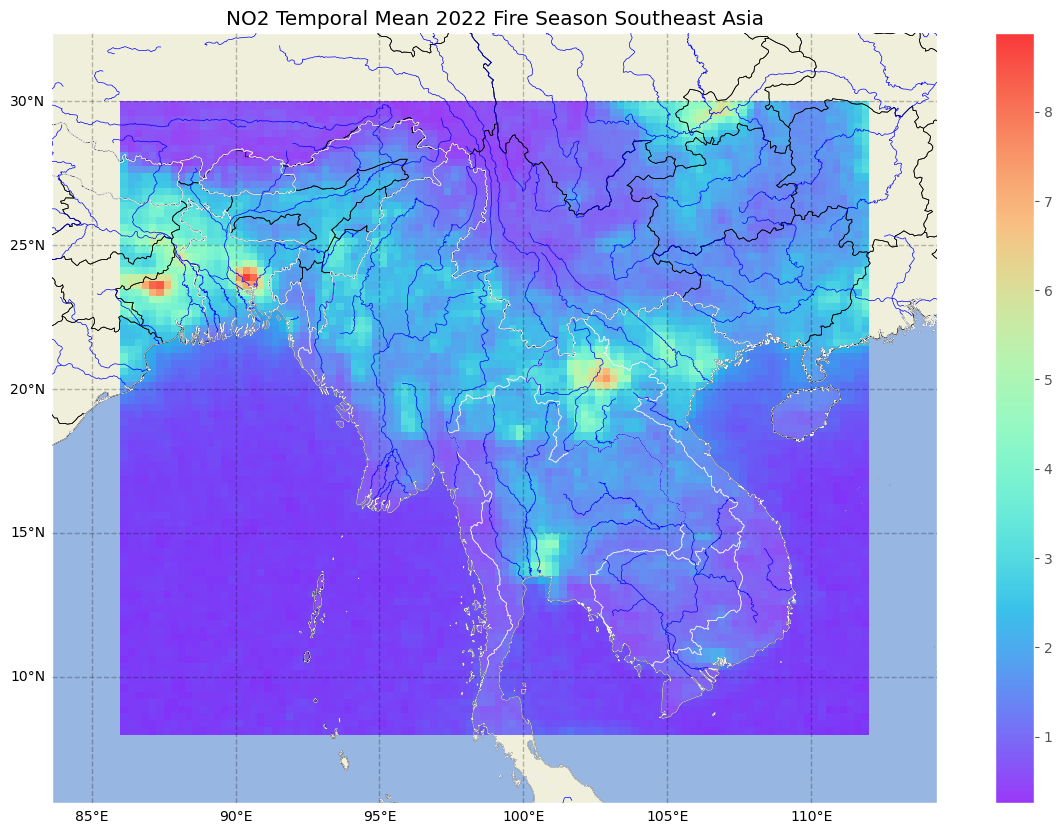

In [55]:
NO2_temporal_mean_data = ideas_processing.temporal_mean(aq_base_url, GMU_NO2_dataset, anomalies_bb, anomalies_start_time, anomalies_end_time)
plotting.map_data(NO2_temporal_mean_data, "NO2 Temporal Mean 2022 Fire Season Southeast Asia")

### O3 Levels

#### O3 Spatial Mean

url
 https://ideas-digitaltwin.jpl.nasa.gov/nexus//timeSeriesSpark?ds=GMU-OMI-0.25deg-monthly-Global-O3&minLon=86&minLat=8&maxLon=112&maxLat=30&startTime=2022-01-01T00:00:00Z&endTime=2022-09-01T00:00:00Z&lowPassFilter=False

Waiting for response from IDEAS...took 2.1123119580443017 seconds


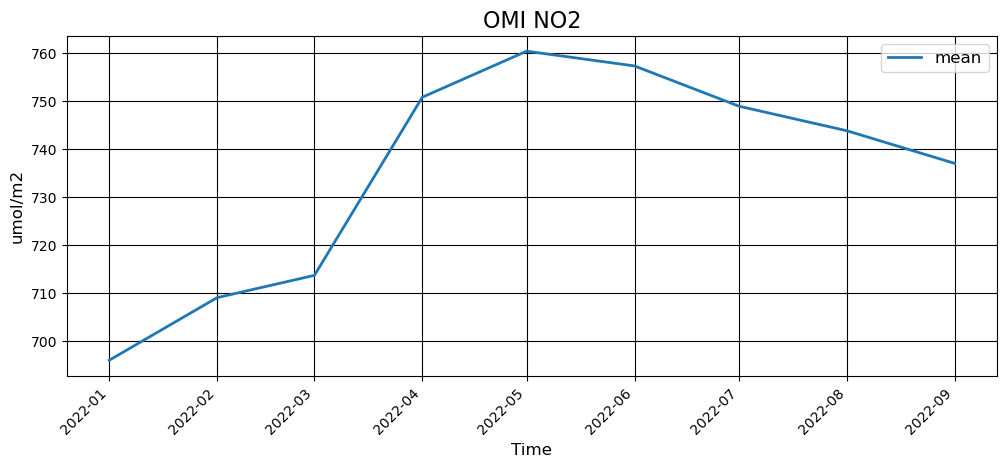

In [75]:
anomalies_O3 = ideas_processing.spatial_timeseries(aq_base_url, GMU_O3_dataset, anomalies_bb, datetime(2022, 1, 1), datetime(2022, 9, 1))
plotting.timeseries_plot([(anomalies_O3['mean'], 'mean')], 'Time', units['NO2'], 'OMI NO2')

#### O3 Temporal Mean

url
 https://ideas-digitaltwin.jpl.nasa.gov/nexus//timeAvgMapSpark?ds=GMU-OMI-0.25deg-monthly-Global-O3&b=86,8,112,30&startTime=2022-02-01T00:00:00Z&endTime=2022-04-30T00:00:00Z

Waiting for response from IDEAS... took 2.2006992080132477 seconds


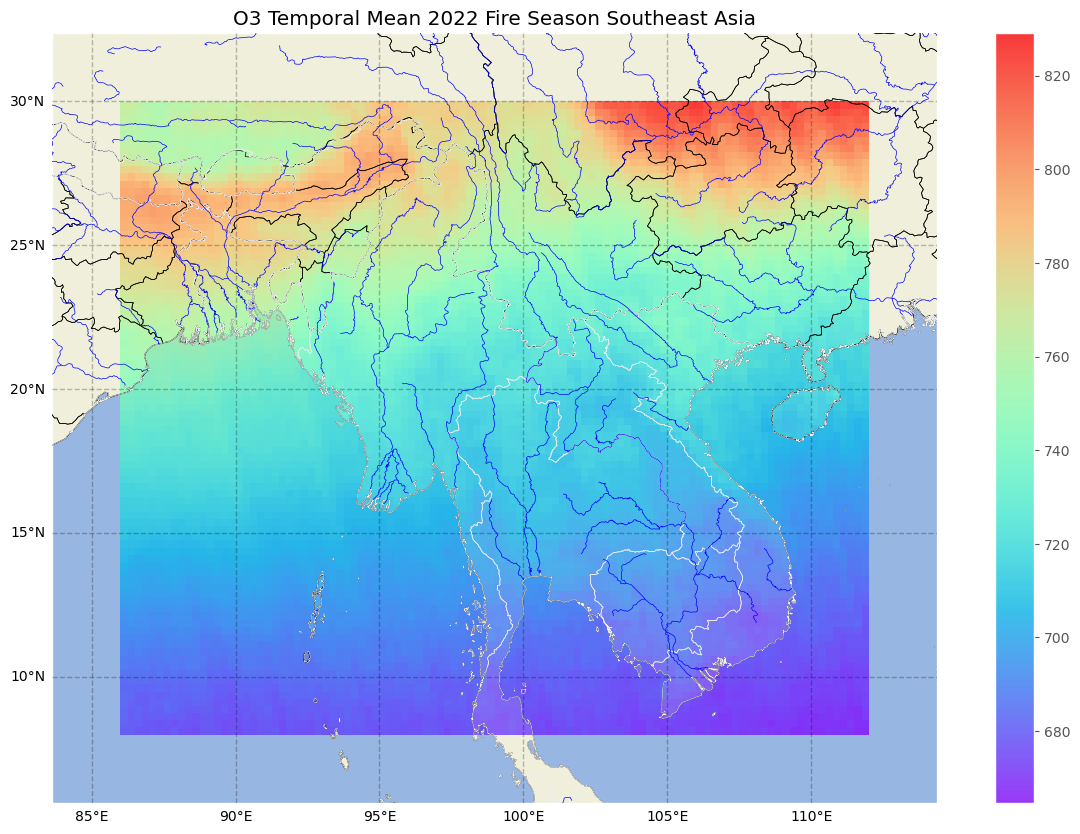

In [57]:
O3_temporal_mean_data = ideas_processing.temporal_mean(aq_base_url, GMU_O3_dataset, anomalies_bb, anomalies_start_time, anomalies_end_time)
plotting.map_data(O3_temporal_mean_data, "O3 Temporal Mean 2022 Fire Season Southeast Asia")